## Data Description

You are provided with historical sales data for 1,115 Rossmann stores. The task is to forecast the "Sales" column for the test set. Note that some stores in the dataset were temporarily closed for refurbishment.

### Files

* train.csv - historical data including Sales
* test.csv - historical data excluding Sales
* sample_submission.csv - a sample submission file in the correct format
* store.csv - supplemental information about the stores

### Data fields

Most of the fields are self-explanatory. The following are descriptions for those that aren't.

* __Id__ - an Id that represents a (Store, Date) duple within the test set
* __Store__ - a unique Id for each store
* __Sales__ - the turnover for any given day (this is what you are predicting)
* __Customers__ - the number of customers on a given day
* __Open__ - an indicator for whether the store was open: 0 = closed, 1 = open
* __StateHoliday__ - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
* __SchoolHoliday__ - indicates if the (Store, Date) was affected by the closure of public schools
* __StoreType__ - differentiates between 4 different store models: a, b, c, d
* __Assortment__ - describes an assortment level: a = basic, b = extra, c = extended
* __CompetitionDistance__ - distance in meters to the nearest competitor store
* __CompetitionOpenSince[Month/Year]__ - gives the approximate year and month of the time the nearest competitor was opened
* __Promo__ - indicates whether a store is running a promo on that day
* __Promo2__ - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
* __Promo2Since[Year/Week]__ - describes the year and calendar week when the store started participating in Promo2
* __PromoInterval__ - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

|**store.csv**|**train.csv**|**test.csv**
|:-|:-|:-
|Store|Store|Store
|StoreType|DayOfWeek|DayOfWeek
|Assortment|Date|Date
|CompetitionDistance|Sales| 
|CompetitionOpenSinceMonth|Customers| 
|CompetitionOpenSinceYear|Open|Open
|Promo2|Promo|Promo
|Promo2SinceWeek|StateHoliday|StateHoliday
|Promo2SinceYear|SchoolHoliday|SchoolHoliday
|PromoInterval| |Id

## 导入工具库

In [817]:
from scipy import stats
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()
from scipy import stats
import itertools
#Scikit-Learn for Modeling
from sklearn import model_selection
from sklearn import metrics
from time import time
import myvisuals as vs
from datetime import datetime

## 导入数据

In [873]:
df_store = pd.read_csv('store.csv',low_memory = False)
df_train = pd.read_csv('train.csv', parse_dates = True, low_memory = False, index_col = 'Date')
df_test = pd.read_csv('test.csv', parse_dates = True, low_memory = False, index_col = 'Date')

print "store dataset has {} rows with {} features each.".format(*df_store.shape)
print "train dataset has {} rows with {} features each.".format(*df_train.shape)
print "test dataset has {} data points with {} variables each.".format(*df_test.shape)

store dataset has 1115 rows with 10 features each.
train dataset has 1017209 rows with 8 features each.
test dataset has 41088 data points with 7 variables each.


In [859]:
test_date_max = df_test.index.max()
test_date_max

Timestamp('2015-09-17 00:00:00')

In [860]:
test_date_min = df_test.index.min()
test_date_min

Timestamp('2015-08-01 00:00:00')

In [861]:
timeDelta = df_test.index.max() - df_test.index.min()
timeDelta

Timedelta('47 days 00:00:00')

In [834]:
val_date_max = df_train.index.max()
val_date_max

Timestamp('2015-07-31 00:00:00')

In [835]:
val_date_min = val_date_max - timeDelta
val_date_min

Timestamp('2015-06-14 00:00:00')

In [845]:
train_date_max = val_date_min - pd.Timedelta('1 days')
train_date_max

Timestamp('2015-06-13 00:00:00')

In [840]:
train_date_min =  df_train.index.min()
train_date_min

Timestamp('2013-01-01 00:00:00')

## 探索数据

### train

* 基本信息

In [376]:
df_train.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1
2015-07-31,2,5,6064,625,1,1,0,1
2015-07-31,3,5,8314,821,1,1,0,1
2015-07-31,4,5,13995,1498,1,1,0,1
2015-07-31,5,5,4822,559,1,1,0,1


In [377]:
df_train.tail()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,,
2013-01-01,1111,2,0,0,0,0,a,1
2013-01-01,1112,2,0,0,0,0,a,1
2013-01-01,1113,2,0,0,0,0,a,1
2013-01-01,1114,2,0,0,0,0,a,1
2013-01-01,1115,2,0,0,0,0,a,1


In [378]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1017209 entries, 2015-07-31 to 2013-01-01
Data columns (total 8 columns):
Store            1017209 non-null int64
DayOfWeek        1017209 non-null int64
Sales            1017209 non-null int64
Customers        1017209 non-null int64
Open             1017209 non-null int64
Promo            1017209 non-null int64
StateHoliday     1017209 non-null object
SchoolHoliday    1017209 non-null int64
dtypes: int64(7), object(1)
memory usage: 69.8+ MB


In [149]:
pd.set_option('display.float_format', lambda x: '%3.f' % x)
df_train.describe()

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday
count,1017209,1017209,1017209,1017209,1017209,1017209,1017209
mean,558,4,5774,633,1,0,0
std,322,2,3850,464,0,0,0
min,1,1,0,0,0,0,0
25%,280,2,3727,405,1,0,0
50%,558,4,5744,609,1,0,0
75%,838,6,7856,837,1,1,0
max,1115,7,41551,7388,1,1,1


* 缺失值

In [380]:
df_train.count(0) / df_train.shape[0] * 100

Store           100
DayOfWeek       100
Sales           100
Customers       100
Open            100
Promo           100
StateHoliday    100
SchoolHoliday   100
dtype: float64

可以看出train数据集中没有缺失值

为了利用数据中的时间信息,添加和时间相关的特征

In [874]:
df_train['Year'] = df_train.index.year
df_train['Month'] = df_train.index.month
df_train['Day'] = df_train.index.day
df_train['WeekOfYear'] = df_train.index.weekofyear

In [7]:
df_train.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear
Date,,,,,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1,2015,7,31,31
2015-07-31,2,5,6064,625,1,1,0,1,2015,7,31,31
2015-07-31,3,5,8314,821,1,1,0,1,2015,7,31,31
2015-07-31,4,5,13995,1498,1,1,0,1,2015,7,31,31
2015-07-31,5,5,4822,559,1,1,0,1,2015,7,31,31


添加`Season`特征

In [875]:
def add_season_feature(df):
    conditions = [
        (((df.index.month == 3) & (df.index.day >= 22)) | ((3 < df.index.month) & (df.index.month < 6)) | ((df.index.month == 6) & (df.index.day < 22))),
        (((df.index.month == 6) & (df.index.day >= 22)) | ((6 < df.index.month) & (df.index.month < 9)) | ((df.index.month == 9) & (df.index.day < 22))),
        (((df.index.month == 9) & (df.index.day >= 22)) | ((9 < df.index.month) & (df.index.month < 12)) | ((df.index.month == 12) & (df.index.day < 22))),
        (((df.index.month == 12) & (df.index.day >= 22)) | ((df.index.month >= 1) & (df.index.month < 3)) | ((df.index.month == 3) & (df.index.day < 22)))
    ]
    choices = ['spring', 'summer', 'autumn','winter']
    df['Season'] = np.select(conditions, choices, default='Error')
    
add_season_feature(df_train)

In [9]:
df_train.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear,Season
Date,,,,,,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1,2015,7,31,31,summer
2015-07-31,2,5,6064,625,1,1,0,1,2015,7,31,31,summer
2015-07-31,3,5,8314,821,1,1,0,1,2015,7,31,31,summer
2015-07-31,4,5,13995,1498,1,1,0,1,2015,7,31,31,summer
2015-07-31,5,5,4822,559,1,1,0,1,2015,7,31,31,summer


添加`Xun`特征

In [876]:
def add_xun_feature(df):
    conditions = [
        (((df.index.day >= 1) & (df.index.day < 11))),
        (((df.index.day >= 11) & (df.index.day < 21))),
        (((df.index.day >= 21) & (df.index.day <= 31)))
    ]
    choices = ['begin', 'middle', 'end']
    df['Xun'] = np.select(conditions, choices, default='Error')
    
add_xun_feature(df_train)

In [153]:
df_train.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear,Season,Xun
Date,,,,,,,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1,2015,7,31,31,summer,end
2015-07-31,2,5,6064,625,1,1,0,1,2015,7,31,31,summer,end
2015-07-31,3,5,8314,821,1,1,0,1,2015,7,31,31,summer,end
2015-07-31,4,5,13995,1498,1,1,0,1,2015,7,31,31,summer,end
2015-07-31,5,5,4822,559,1,1,0,1,2015,7,31,31,summer,end


* 单变量分析

__1.1.1 Sales__

In [385]:
df_train.Sales.describe()

count   1017209
mean       5774
std        3850
min           0
25%        3727
50%        5744
75%        7856
max       41551
Name: Sales, dtype: float64

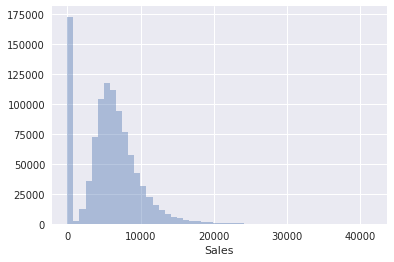

In [386]:
sns.distplot(df_train.Sales, kde = False)

发现`Sales`为`0`的很多，观察一下这些数据

In [387]:
df_train[df_train.Sales == 0]

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear,Season
Date,,,,,,,,,,,,,
2015-07-31,292,5,0,0,0,1,0,1,2015,7,31,31,summer
2015-07-31,876,5,0,0,0,1,0,1,2015,7,31,31,summer
2015-07-30,292,4,0,0,0,1,0,1,2015,7,30,31,summer
2015-07-30,876,4,0,0,0,1,0,1,2015,7,30,31,summer
2015-07-29,292,3,0,0,0,1,0,1,2015,7,29,31,summer
2015-07-29,876,3,0,0,0,1,0,1,2015,7,29,31,summer
2015-07-28,292,2,0,0,0,1,0,1,2015,7,28,31,summer
2015-07-28,876,2,0,0,0,1,0,1,2015,7,28,31,summer
2015-07-27,292,1,0,0,0,1,0,1,2015,7,27,31,summer


发现有172871条数据的`Sales`为`0`,发现这些数据大部分的`Open`也为`0`,是否说明只要`Open`为`0`,`Sales`也为0呢？

In [388]:
df_train[ df_train.Sales == 0 ].count()[0]

172871

In [389]:
df_train[df_train.Open == 0 ].count()[0]

172817

In [390]:
df_train[(df_train.Open == 1) & (df_train.Sales == 0) ].count()[0]

54

发现有时`Open`为`1`,`Sales`也会为`0`

In [391]:
df_train[df_train.Sales != 0].Sales.describe()

count   844338
mean      6956
std       3104
min         46
25%       4859
50%       6369
75%       8360
max      41551
Name: Sales, dtype: float64

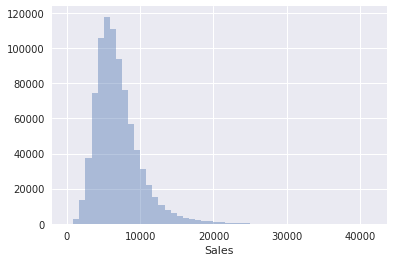

In [392]:
sns.distplot(df_train.Sales[df_train.Sales != 0] , kde = False)

观察一下`Sales`最大值的数据

In [393]:
df_train[df_train.Sales == df_train.Sales.max()]

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear,Season
Date,,,,,,,,,,,,,
2015-06-22,909,1,41551,1721,1,0,0,0,2015,6,22,26,summer


无法确定这条数据是否为异常值，但是这一天`Promo`为0,不知为什么会成为最大值

__1.1.2 Customers__

In [394]:
df_train.Customers.describe()

count   1017209
mean        633
std         464
min           0
25%         405
50%         609
75%         837
max        7388
Name: Customers, dtype: float64

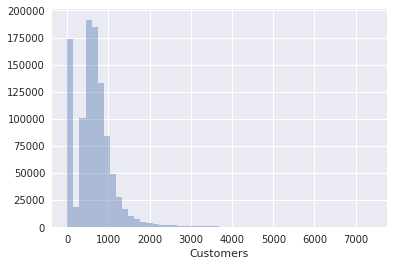

In [395]:
sns.distplot(df_train.Customers, kde = False)

同样有很多`Customers`为0的数据

In [396]:
df_train[ df_train.Customers == 0 ].count()[0]

172869

`Customers`为0,是否`Sales`一定为0 ？

In [397]:
df_train[ (df_train.Customers == 0) & (df_train.Sales == 0) ].count()[0]

172869

是合理的，没有异常情况出现

In [398]:
df_train[df_train.Sales != 0].Customers.describe()

count   844338
mean       763
std        401
min          8
25%        519
50%        676
75%        893
max       7388
Name: Customers, dtype: float64

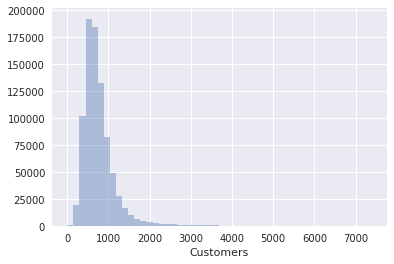

In [399]:
sns.distplot(df_train.Customers[df_train.Customers != 0] , kde = False)

观察一下`Customers`最大的数据

In [400]:
df_train[df_train.Customers == df_train.Customers.max()]

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear,Season
Date,,,,,,,,,,,,,
2013-01-22,817,2,27190,7388,1,1,0,0,2013,1,22,4,winter


这天`Promo`为1,合理,不是异常值

__1.1.3 Open__

In [401]:
df_train[df_train.Sales != 0].Open.describe()

count   844338
mean         1
std          0
min          1
25%          1
50%          1
75%          1
max          1
Name: Open, dtype: float64

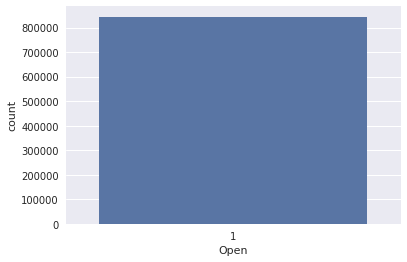

In [402]:
sns.countplot(x = 'Open', data = df_train[df_train.Sales != 0])

__1.1.4 Promo__

In [403]:
df_train[df_train.Sales != 0].Open.describe()

count   844338
mean         1
std          0
min          1
25%          1
50%          1
75%          1
max          1
Name: Open, dtype: float64

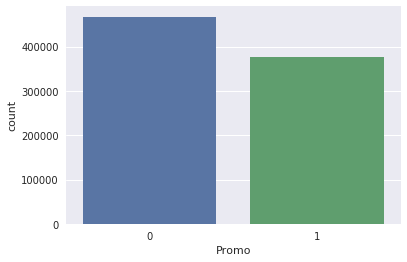

In [404]:
sns.countplot(x = 'Promo', data = df_train[df_train.Sales != 0])

__1.1.5 StateHoliday__

In [405]:
df_train[df_train.Sales != 0].StateHoliday.describe()

count     844338
unique         4
top            0
freq      843428
Name: StateHoliday, dtype: object

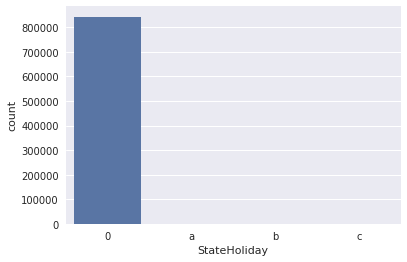

In [406]:
sns.countplot(x = 'StateHoliday', data = df_train[df_train.Sales != 0])

__1.1.6 SchoolHoliday__

In [407]:
df_train[df_train.Sales != 0].SchoolHoliday.describe()

count   844338
mean         0
std          0
min          0
25%          0
50%          0
75%          0
max          1
Name: SchoolHoliday, dtype: float64

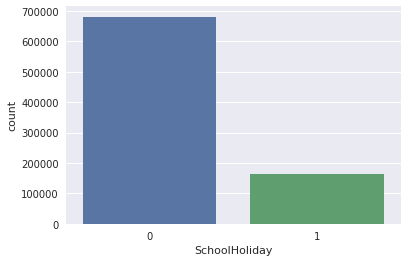

In [408]:
sns.countplot(x = 'SchoolHoliday', data = df_train[df_train.Sales != 0])

__1.1.7 DayOfWeek__

In [409]:
df_train[df_train.Sales != 0].DayOfWeek.describe()

count   844338
mean         4
std          2
min          1
25%          2
50%          3
75%          5
max          7
Name: DayOfWeek, dtype: float64

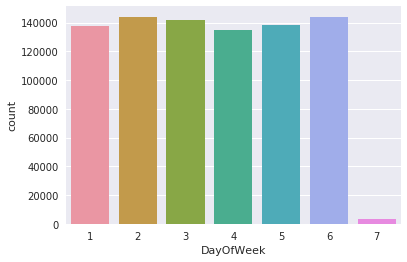

In [410]:
sns.countplot(x = 'DayOfWeek', data = df_train[df_train.Sales != 0])

__1.1.8 Season__

In [10]:
df_train[df_train.Sales != 0].Season.describe()

count     844338
unique         4
top       spring
freq      245529
Name: Season, dtype: object

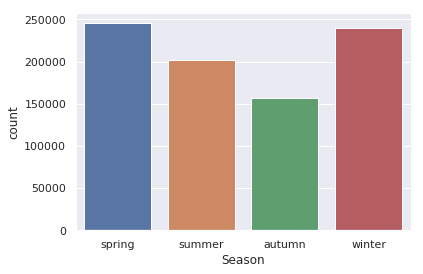

In [11]:
sns.countplot(x = 'Season', data = df_train[df_train.Sales != 0], order = ["spring","summer","autumn","winter"])

* 双变量分析

__1.2.1 Customers × Sales__

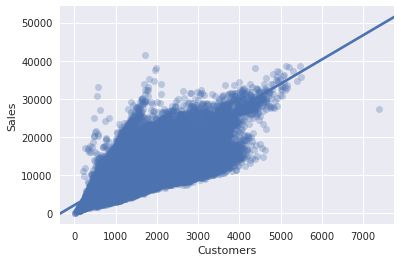

In [413]:
sns.regplot(x='Customers', y='Sales', data = df_train[df_train.Sales != 0], scatter_kws={'alpha':0.3})

__1.2.2 Open × Sales__

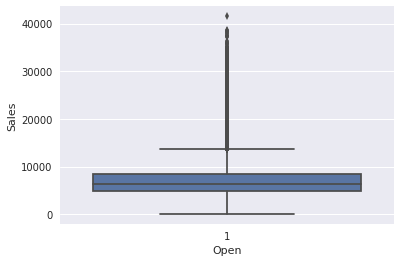

In [414]:
sns.boxplot(x='Open', y='Sales', data=df_train[df_train.Sales != 0])

__1.2.3 Promo × Sales__

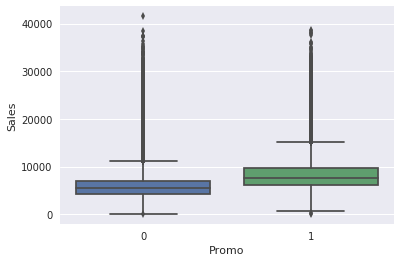

In [415]:
sns.boxplot(x='Promo', y='Sales', data=df_train[df_train.Sales != 0])

__1.2.4 StateHoliday × Sales__

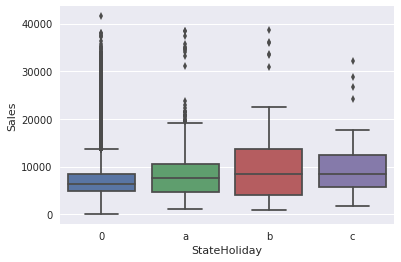

In [416]:
sns.boxplot(x='StateHoliday', y='Sales', data=df_train[df_train.Sales != 0])

__1.2.5 SchoolHoliday × Sales__

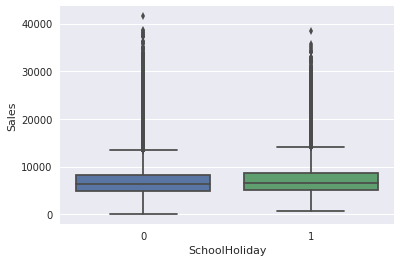

In [417]:
sns.boxplot(x='SchoolHoliday', y='Sales', data=df_train[df_train.Sales != 0])

__1.2.6 DayOfWeek × Sales__

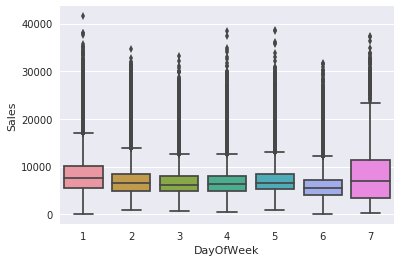

In [418]:
sns.boxplot(x='DayOfWeek', y='Sales', data=df_train[df_train.Sales != 0])

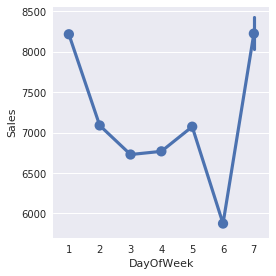

In [419]:
sns.factorplot(data = df_train[df_train.Sales != 0], x = 'DayOfWeek', y = "Sales")

__1.2.7 DayOfWeek × Customres__

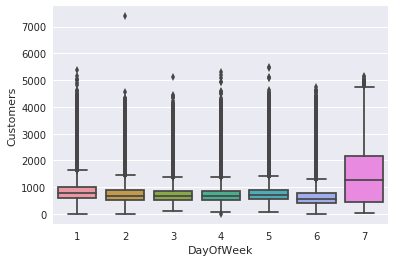

In [420]:
sns.boxplot(x='DayOfWeek', y='Customers', data=df_train[df_train.Customers != 0])

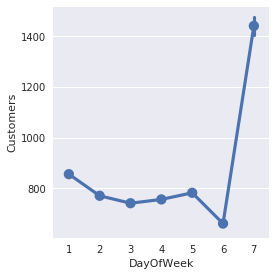

In [421]:
sns.factorplot(data = df_train[df_train.Customers != 0], x = 'DayOfWeek', y = "Customers")

__1.2.8 Year × Sales__

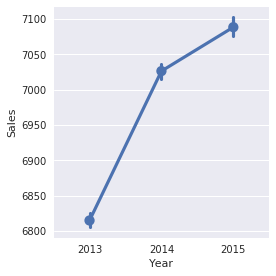

In [422]:
sns.factorplot(data = df_train[df_train.Sales != 0], x = 'Year', y = "Sales")

__1.2.9 Year × Customers__

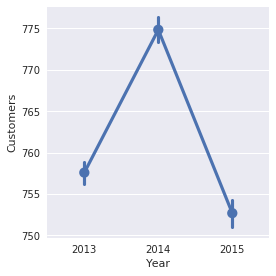

In [423]:
sns.factorplot(data = df_train[df_train.Customers != 0], x = 'Year', y = "Customers")

__1.2.10 Month × Sales__

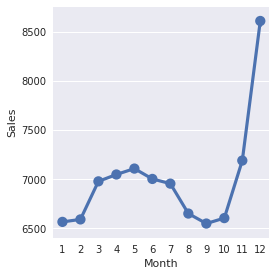

In [424]:
sns.factorplot(data = df_train[df_train.Sales != 0], x = 'Month', y = "Sales")

__1.2.11 Month × Customers__

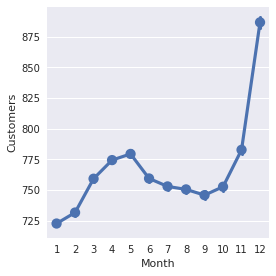

In [425]:
sns.factorplot(data = df_train[df_train.Customers != 0], x = 'Month', y = "Customers")

__1.2.12 Day × Sales__ 

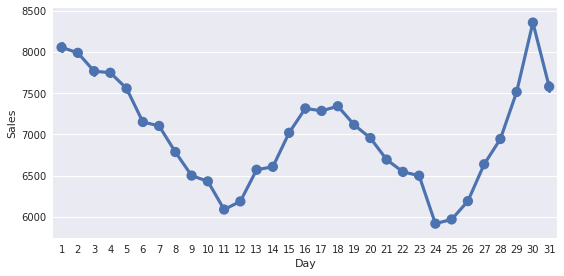

In [426]:
sns.factorplot(data = df_train[df_train.Sales != 0], x = 'Day', y = "Sales", aspect = 2)

__1.2.13 Day × Customers__

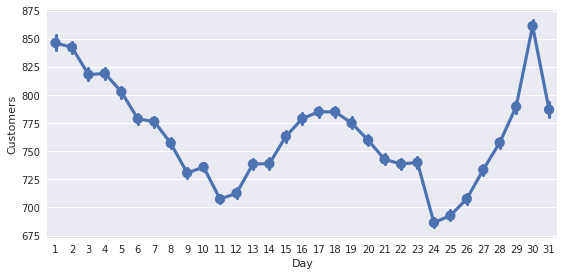

In [427]:
sns.factorplot(data = df_train[df_train.Customers != 0], x = 'Day', y = "Customers", aspect = 2)

__1.2.14 Season × Customers__

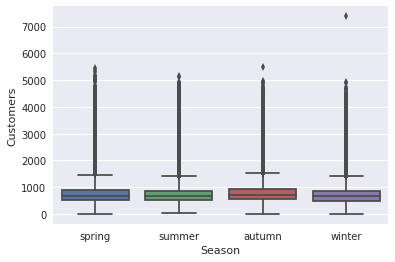

In [428]:
sns.boxplot(x='Season', y='Customers', data=df_train[df_train.Customers != 0], order = ["spring","summer","autumn","winter"])

__1.2.15 Season × Sales__

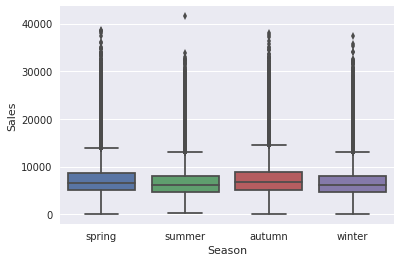

In [429]:
sns.boxplot(x='Season', y='Sales', data=df_train[df_train.Sales != 0], order = ["spring","summer","autumn","winter"])

__1.2.16 Xun × Sales__

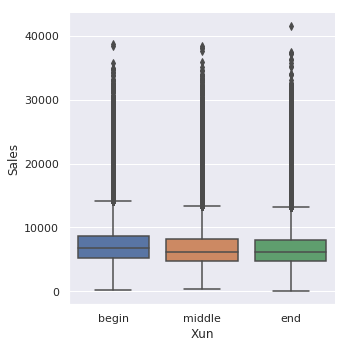

In [92]:
sns.catplot(data = df_train[df_train.Sales != 0], x = 'Xun', y = "Sales",
           kind = "box",
           order = ["begin","middle","end"])

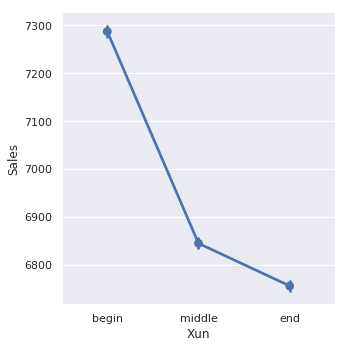

In [90]:
sns.catplot(data = df_train[df_train.Sales != 0], x = 'Xun', y = "Sales",
           kind = "point",
           order = ["begin","middle","end"])

__1.2.17 Xun × Customers__

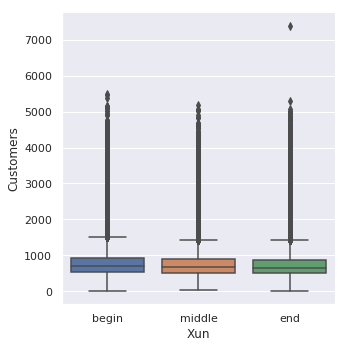

In [93]:
sns.catplot(data = df_train[df_train.Customers != 0], x = 'Xun', y = "Customers",
           kind = "box",
           order = ["begin","middle","end"])

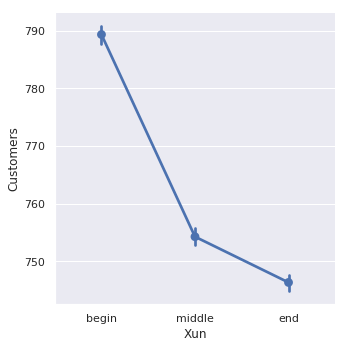

In [91]:
sns.catplot(data = df_train[df_train.Customers != 0], x = 'Xun', y = "Customers",
           kind = "point",
           order = ["begin","middle","end"])

* 多变量分析

__1.3.1 Promo × Customres × Sales__

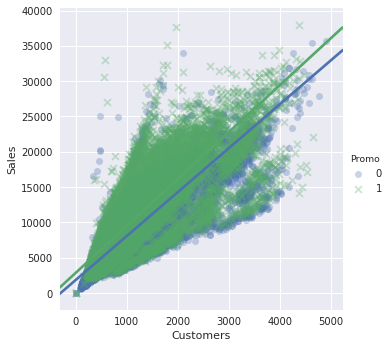

In [230]:
sns.lmplot(x='Customers', y='Sales', hue='Promo', data=df_train_store, fit_reg=True, markers=["o", "x"], scatter_kws={'alpha':0.3})

`Promo`为1时确实`Sales`提升了

__1.3.2 Promo × DayOfWeek × Sales__

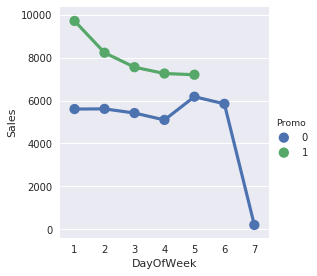

In [325]:
sns.factorplot(data = df_train[df_train.Sales != 0], x = 'DayOfWeek', y = "Sales", hue = "Promo")

__1.3.3 Season × DayOfWeek × Sales__

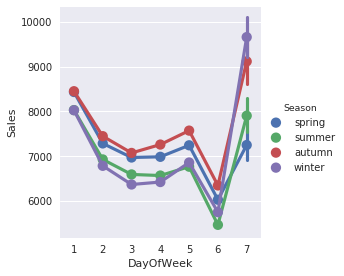

In [431]:
sns.factorplot(data = df_train[df_train.Sales != 0], x = 'DayOfWeek', y = "Sales", hue = "Season", hue_order = ["spring","summer","autumn","winter"])

__1.3.4 Promo × DayOfWeek × Customres__

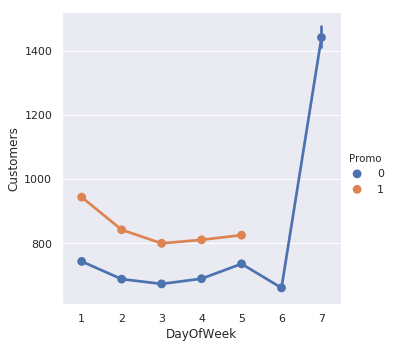

In [27]:
sns.catplot(data = df_train[df_train.Customers != 0], x = 'DayOfWeek', y = "Customers", hue = "Promo", kind="point")

__1.3.5 Season × DayOfWeek × Customres__

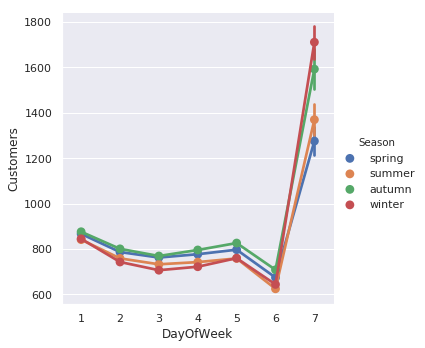

In [28]:
sns.catplot(data = df_train[df_train.Customers != 0], x = 'DayOfWeek', y = "Customers", hue = "Season", hue_order = ["spring","summer","autumn","winter"], kind="point")

__1.3.6 Season × Day × Customres__

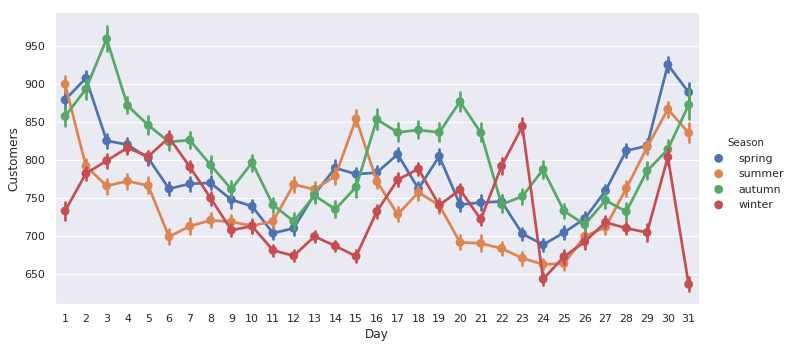

In [29]:
sns.catplot(data = df_train[df_train.Customers != 0], x = 'Day', y = "Customers", hue = "Season", hue_order = ["spring","summer","autumn","winter"], kind="point", aspect = 2)

__1.3.7 Season × Day × Sales__

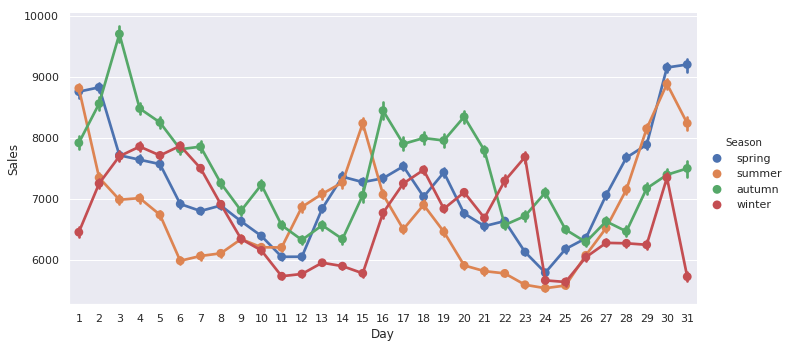

In [30]:
sns.catplot(data = df_train[df_train.Sales != 0], x = 'Day', y = "Sales", hue = "Season", hue_order = ["spring","summer","autumn","winter"], kind="point", aspect = 2)

__1.3.8 Season × Day × Sales × Promo__

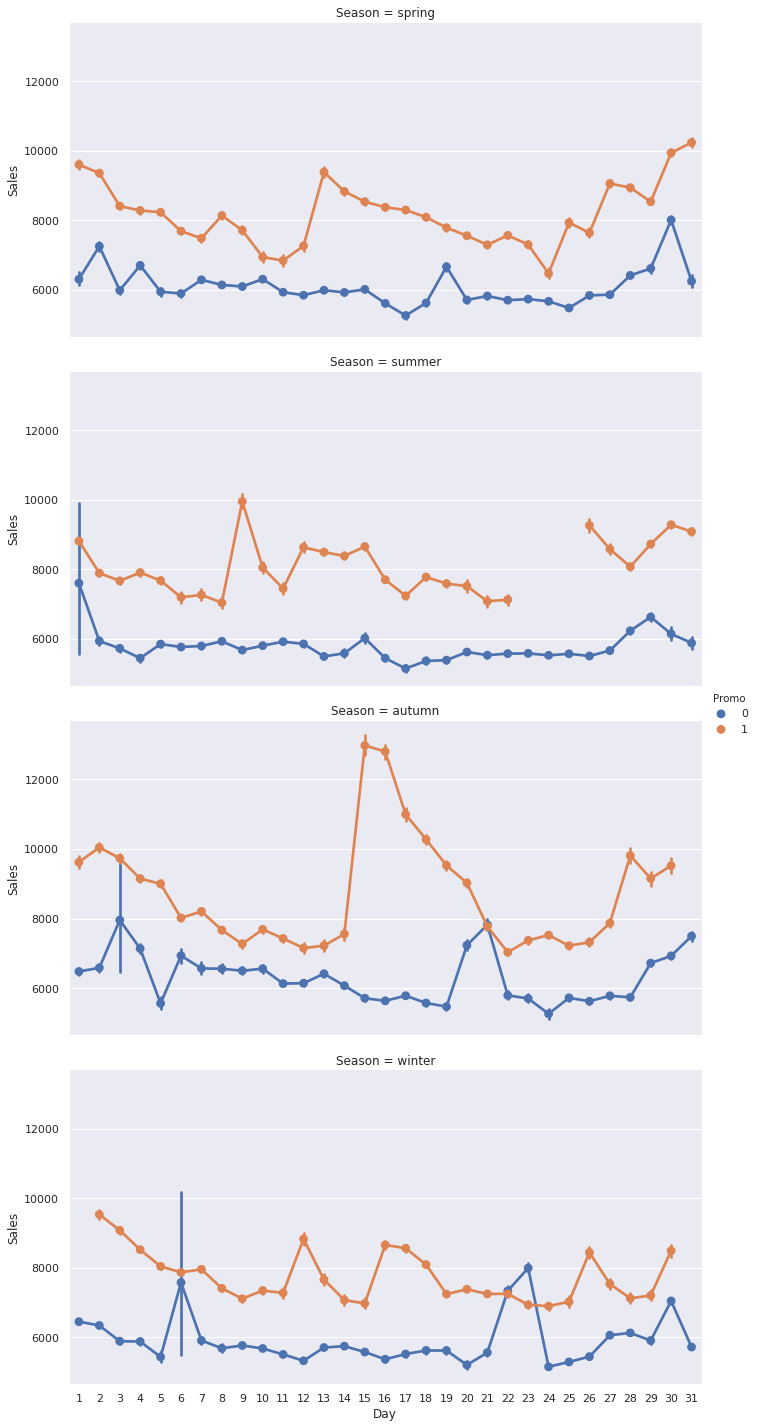

In [58]:
sns.catplot(data = df_train[df_train.Sales != 0], x = 'Day', y = "Sales", 
            hue = "Promo",
            row = "Season",
            row_order = ["spring","summer","autumn","winter"], 
            kind="point", 
            aspect = 2)

__1.3.9 Season × Day × Customers × Promo__

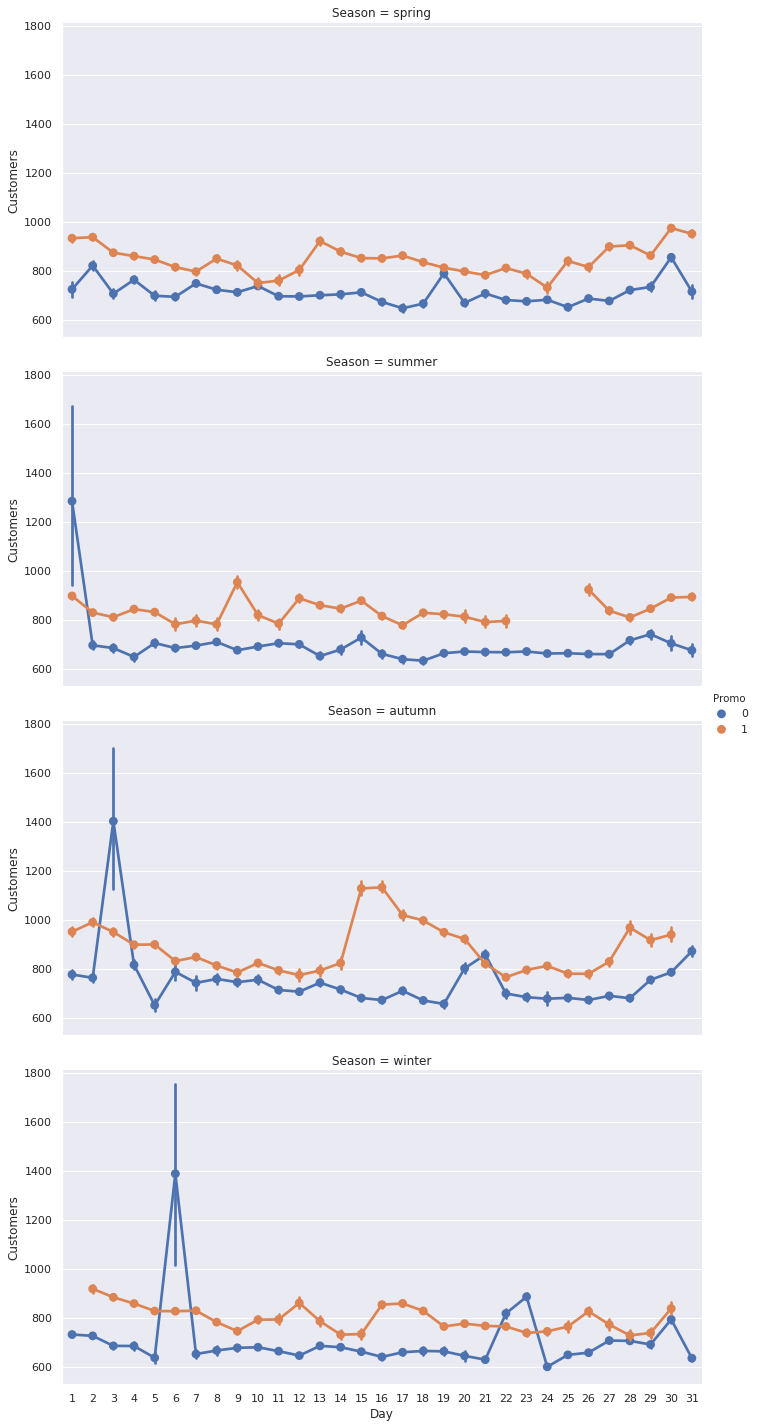

In [59]:
sns.catplot(data = df_train[df_train.Customers != 0], x = 'Day', y = "Customers", 
            hue = "Promo",
            row = "Season",
            row_order = ["spring","summer","autumn","winter"], 
            kind="point", 
            aspect = 2)

__1.3.10 Season × Xun × Customers__

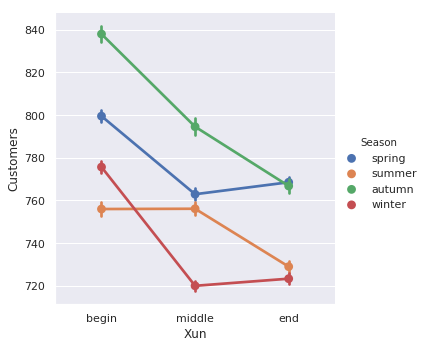

In [95]:
sns.catplot(data = df_train[df_train.Customers != 0], x = 'Xun', y = "Customers",
            order = ["begin","middle","end"],
            hue = "Season", hue_order = ["spring","summer","autumn","winter"], 
            kind="point")

__1.3.11 Season × Xun × Sales__

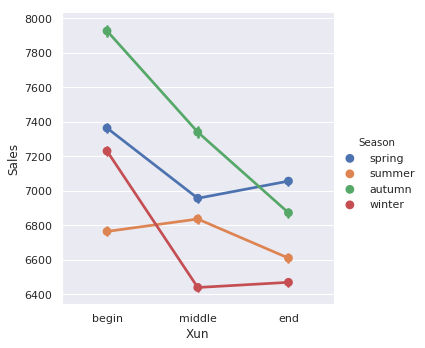

In [96]:
sns.catplot(data = df_train[df_train.Sales != 0], x = 'Xun', y = "Sales",
            order = ["begin","middle","end"],
            hue = "Season", hue_order = ["spring","summer","autumn","winter"], 
            kind="point")

__1.3.12 Season × Xun × Sales × Promo__

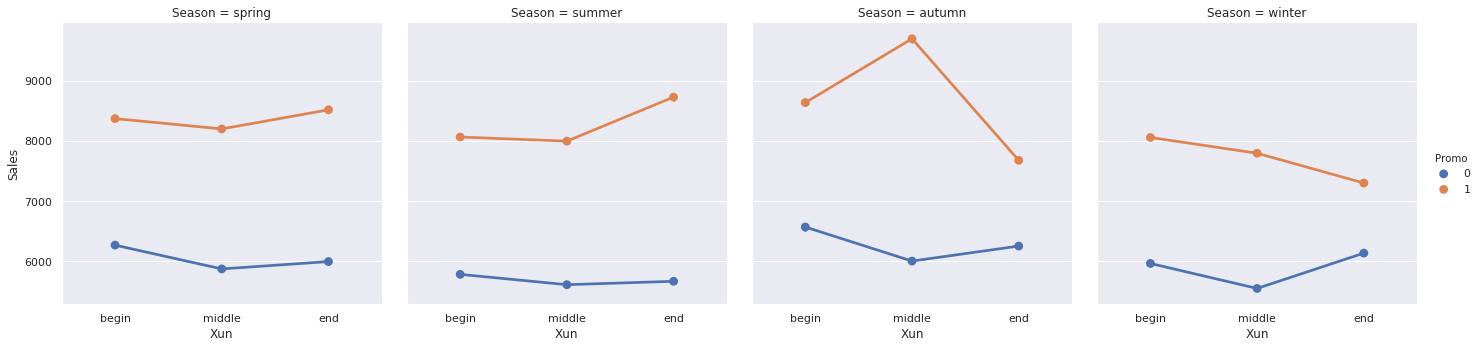

In [99]:
sns.catplot(data = df_train[df_train.Sales != 0], x = 'Xun', y = "Sales", 
            hue = "Promo",
            order = ["begin","middle","end"],
            col = "Season",col_order = ["spring","summer","autumn","winter"], 
            kind="point")

### store

* 基本信息

In [440]:
df_store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270,9,2008,0,nan,nan,NaN
1,2,a,a,570,11,2007,1,13,2010,"Jan,Apr,Jul,Oct"
2,3,a,a,14130,12,2006,1,14,2011,"Jan,Apr,Jul,Oct"
3,4,c,c,620,9,2009,0,nan,nan,NaN
4,5,a,a,29910,4,2015,0,nan,nan,NaN


In [441]:
df_store.tail()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
1110,1111,a,a,1900,6,2014,1,31,2013,"Jan,Apr,Jul,Oct"
1111,1112,c,c,1880,4,2006,0,nan,nan,NaN
1112,1113,a,c,9260,nan,nan,0,nan,nan,NaN
1113,1114,a,c,870,nan,nan,0,nan,nan,NaN
1114,1115,d,c,5350,nan,nan,1,22,2012,"Mar,Jun,Sept,Dec"


In [442]:
df_store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
Store                        1115 non-null int64
StoreType                    1115 non-null object
Assortment                   1115 non-null object
CompetitionDistance          1112 non-null float64
CompetitionOpenSinceMonth    761 non-null float64
CompetitionOpenSinceYear     761 non-null float64
Promo2                       1115 non-null int64
Promo2SinceWeek              571 non-null float64
Promo2SinceYear              571 non-null float64
PromoInterval                571 non-null object
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


In [443]:
df_store.describe()

,Store,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear
count,1115,1112,761,761,1115,571,571
mean,558,5405,7,2009,1,24,2012
std,322,7663,3,6,1,14,2
min,1,20,1,1900,0,1,2009
25%,280,718,4,2006,0,13,2011
50%,558,2325,8,2010,1,22,2012
75%,836,6882,10,2013,1,37,2013
max,1115,75860,12,2015,1,50,2015


* 缺失值

In [596]:
df_store.count(0) / df_store.shape[0] * 100

Store                       100
StoreType                   100
Assortment                  100
CompetitionDistance         100
CompetitionOpenSinceMonth    68
CompetitionOpenSinceYear     68
Promo2                      100
Promo2SinceWeek              51
Promo2SinceYear              51
PromoInterval                51
dtype: float64

In [597]:
df_store.isnull().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

1. `CompetitionDistance`有很少的缺失值
2. `CompetitionOpenSinceMonth`和`CompetitionOpenSinceYear`的缺失值个数相同，`Promo2SinceWeek`,`Promo2SinceYear`,`PromoInterval`的缺失值个数相同，个数相同说明这些特征之间有一些联系

In [446]:
df_store[pd.isnull(df_store.CompetitionDistance)]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
290,291,d,a,nan,nan,nan,0,nan,nan,NaN
621,622,a,c,nan,nan,nan,0,nan,nan,NaN
878,879,d,a,nan,nan,nan,1,5,2013,"Feb,May,Aug,Nov"


In [447]:
df_store[pd.isnull(df_store.CompetitionOpenSinceMonth)]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
11,12,a,c,1070,nan,nan,1,13,2010,"Jan,Apr,Jul,Oct"
12,13,d,a,310,nan,nan,1,45,2009,"Feb,May,Aug,Nov"
15,16,a,c,3270,nan,nan,0,nan,nan,NaN
18,19,a,c,3240,nan,nan,1,22,2011,"Mar,Jun,Sept,Dec"
21,22,a,a,1040,nan,nan,1,22,2012,"Jan,Apr,Jul,Oct"
25,26,d,a,2300,nan,nan,0,nan,nan,NaN
28,29,d,c,2170,nan,nan,0,nan,nan,NaN
31,32,a,a,2910,nan,nan,1,45,2009,"Feb,May,Aug,Nov"
39,40,a,a,180,nan,nan,1,45,2009,"Feb,May,Aug,Nov"
40,41,d,c,1180,nan,nan,1,31,2013,"Jan,Apr,Jul,Oct"


In [448]:
df_store[pd.isnull(df_store.Promo2SinceWeek)]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270,9,2008,0,nan,nan,NaN
3,4,c,c,620,9,2009,0,nan,nan,NaN
4,5,a,a,29910,4,2015,0,nan,nan,NaN
5,6,a,a,310,12,2013,0,nan,nan,NaN
6,7,a,c,24000,4,2013,0,nan,nan,NaN
7,8,a,a,7520,10,2014,0,nan,nan,NaN
8,9,a,c,2030,8,2000,0,nan,nan,NaN
9,10,a,a,3160,9,2009,0,nan,nan,NaN
15,16,a,c,3270,nan,nan,0,nan,nan,NaN
22,23,d,a,4060,8,2005,0,nan,nan,NaN


In [449]:
df_store[pd.isnull(df_store.Promo2SinceWeek) & df_store.Promo2 == 1 ]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval


In [450]:
df_store[pd.isnull(df_store.Promo2SinceWeek) & pd.isnull(df_store.Promo2SinceYear) & pd.isnull(df_store.PromoInterval)].count()[0]

544

说明当`Promo2`为`0`时`Promo2SinceWeek`,`Promo2SinceYear`,`PromoInterval`全部缺失  

* 单变量分析

__2.1.1 StoreType__

In [451]:
df_store.StoreType.describe()

count     1115
unique       4
top          a
freq       602
Name: StoreType, dtype: object

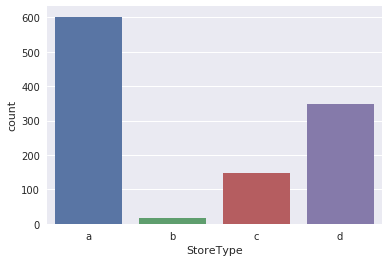

In [452]:
sns.countplot(x = 'StoreType', data = df_store, order=["a", "b", "c", "d"])

__2.1.2 Assortment__

In [453]:
df_store.Assortment.describe()

count     1115
unique       3
top          a
freq       593
Name: Assortment, dtype: object

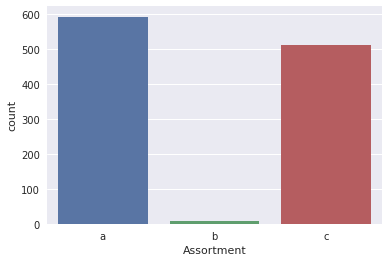

In [454]:
sns.countplot(x = 'Assortment', data = df_store, order=["a", "b", "c"])

__2.1.3 CompetitionDistance (has nan)__

In [455]:
df_store[pd.notnull(df_store.CompetitionDistance)].CompetitionDistance.describe()

count    1112
mean     5405
std      7663
min        20
25%       718
50%      2325
75%      6882
max     75860
Name: CompetitionDistance, dtype: float64

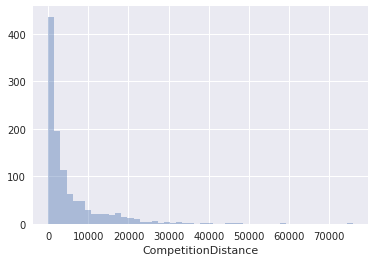

In [456]:
sns.distplot(df_store[pd.notnull(df_store.CompetitionDistance)].CompetitionDistance , kde = False)

处理`CompetitionDistance`缺失值

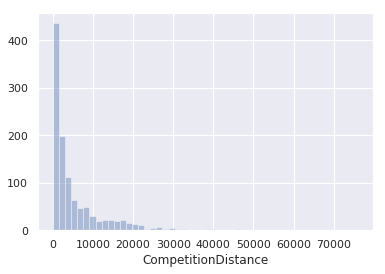

In [877]:
df_store['CompetitionDistance'].fillna(df_store['CompetitionDistance'].median(), inplace = True)

sns.distplot(df_store.CompetitionDistance , kde = False)

__2.1.4 CompetitionOpenSinceMonth (has nan)__

In [458]:
df_store[pd.notnull(df_store.CompetitionOpenSinceMonth)].CompetitionOpenSinceMonth.describe()

count   761
mean      7
std       3
min       1
25%       4
50%       8
75%      10
max      12
Name: CompetitionOpenSinceMonth, dtype: float64

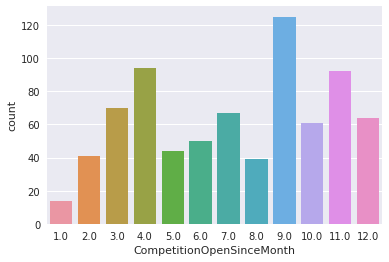

In [459]:
sns.countplot(x = 'CompetitionOpenSinceMonth', data = df_store[pd.notnull(df_store.CompetitionOpenSinceMonth)])

处理`CompetitionOpenSinceMonth`缺失值

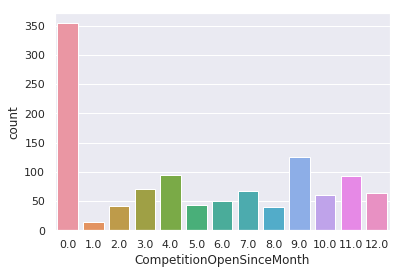

In [878]:
df_store.CompetitionOpenSinceMonth.fillna(0,inplace=True)
sns.countplot(x = 'CompetitionOpenSinceMonth', data = df_store)

__2.1.5 CompetitionOpenSinceYear (has nan)__

In [461]:
df_store[pd.notnull(df_store.CompetitionOpenSinceYear)].CompetitionOpenSinceYear.describe()

count    761
mean    2009
std        6
min     1900
25%     2006
50%     2010
75%     2013
max     2015
Name: CompetitionOpenSinceYear, dtype: float64

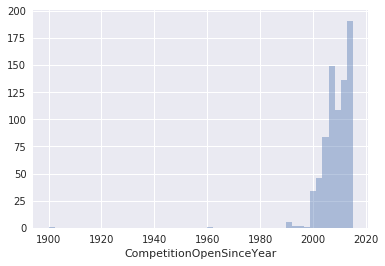

In [462]:
sns.distplot(df_store[pd.notnull(df_store.CompetitionOpenSinceYear)].CompetitionOpenSinceYear , kde = False)

1900年的值很奇怪

In [463]:
df_store[pd.notnull(df_store.CompetitionOpenSinceYear)].CompetitionOpenSinceYear.unique()

array([2008., 2007., 2006., 2009., 2015., 2013., 2014., 2000., 2011.,
       2010., 2005., 1999., 2003., 2012., 2004., 2002., 1961., 1995.,
       2001., 1990., 1994., 1900., 1998.])

In [464]:
df_store[df_store['CompetitionOpenSinceYear'] == 1900]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
814,815,a,a,590,1,1900,1,40,2014,"Jan,Apr,Jul,Oct"


处理`CompetitionOpenSinceYear`的缺失值

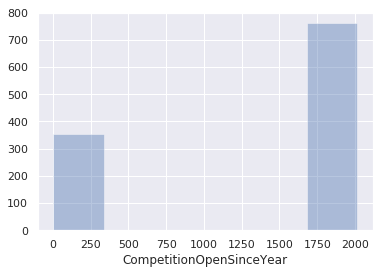

In [879]:
df_store.CompetitionOpenSinceYear.fillna(0,inplace=True)
sns.distplot(df_store.CompetitionOpenSinceYear , kde = False)

__2.1.6 Promo2__

In [467]:
df_store.Promo2.describe()

count   1114
mean       1
std        1
min        0
25%        0
50%        1
75%        1
max        1
Name: Promo2, dtype: float64

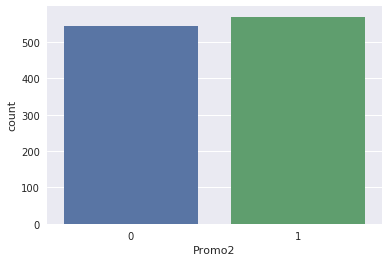

In [468]:
sns.countplot(x = 'Promo2', data = df_store)

__2.1.7 Promo2SinceWeek (has nan)__

In [469]:
df_store[pd.notnull(df_store.Promo2SinceWeek)].Promo2SinceWeek.describe()

count   570
mean     24
std      14
min       1
25%      13
50%      22
75%      37
max      50
Name: Promo2SinceWeek, dtype: float64

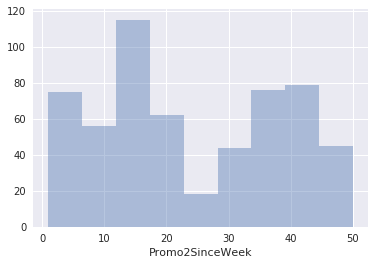

In [470]:
sns.distplot(df_store[pd.notnull(df_store.Promo2SinceWeek)].Promo2SinceWeek , kde = False)

处理`Promo2SinceWeek`的缺失值

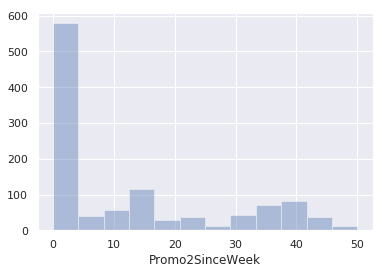

In [880]:
df_store.Promo2SinceWeek.fillna(0,inplace=True)
sns.distplot(df_store.Promo2SinceWeek , kde = False)

__2.1.8 Promo2SinceYear (has nan)__

In [472]:
df_store[pd.notnull(df_store.Promo2SinceYear)].Promo2SinceYear.describe()

count    570
mean    2012
std        2
min     2009
25%     2011
50%     2012
75%     2013
max     2015
Name: Promo2SinceYear, dtype: float64

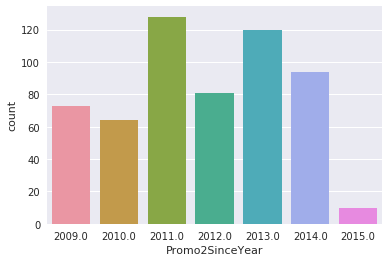

In [473]:
sns.countplot(x = 'Promo2SinceYear', data = df_store[pd.notnull(df_store.Promo2SinceYear)])

处理`Promo2SinceYear`的缺失值

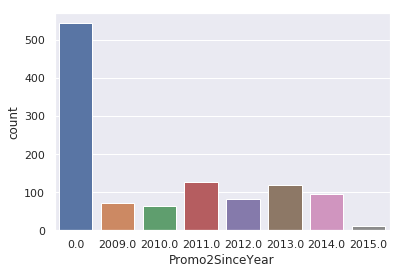

In [881]:
df_store.Promo2SinceYear.fillna(0,inplace=True)
sns.countplot(x = 'Promo2SinceYear', data = df_store)

__2.1.9 PromoInterval (has nan)__

In [475]:
df_store[pd.notnull(df_store.PromoInterval)].PromoInterval.describe()

count                 570
unique                  3
top       Jan,Apr,Jul,Oct
freq                  334
Name: PromoInterval, dtype: object

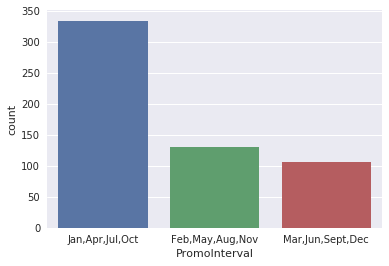

In [476]:
sns.countplot(x = 'PromoInterval', data = df_store[pd.notnull(df_store.PromoInterval)])

处理`PromoInterval`的缺失值

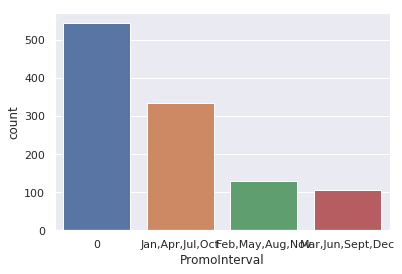

In [882]:
df_store.PromoInterval.fillna(0,inplace=True)
sns.countplot(x = 'PromoInterval', data = df_store)

In [883]:
df_store.count(0) / df_store.shape[0] * 100

Store                       100
StoreType                   100
Assortment                  100
CompetitionDistance         100
CompetitionOpenSinceMonth   100
CompetitionOpenSinceYear    100
Promo2                      100
Promo2SinceWeek             100
Promo2SinceYear             100
PromoInterval               100
dtype: float64

为观察`Store`中的数据对`Sales`的影响，需要合并`df_train`和`df_store`两个数据

In [884]:
df_train_store = pd.merge(df_train, df_store, how = 'inner', on = 'Store')

为了不影响模型的效果,删除`Sales`为0且`Open`为0的数据,因为这些数据是没有意义的

In [885]:
df_train_store=df_train_store.drop( df_train_store[df_train_store['Sales'] == 0].index)

In [165]:
df_train_store.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,...,Xun,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,5263,555,1,1,0,1,2015,7,...,end,c,a,1270,9,2008,0,0,0,0
1,1,4,5020,546,1,1,0,1,2015,7,...,end,c,a,1270,9,2008,0,0,0,0
2,1,3,4782,523,1,1,0,1,2015,7,...,end,c,a,1270,9,2008,0,0,0,0
3,1,2,5011,560,1,1,0,1,2015,7,...,end,c,a,1270,9,2008,0,0,0,0
4,1,1,6102,612,1,1,0,1,2015,7,...,end,c,a,1270,9,2008,0,0,0,0


In [166]:
df_train_store.tail()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,...,Xun,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
1016444,1115,1,6905,471,1,1,0,1,2013,1,...,begin,d,c,5350,0,0,1,22,2012,"Mar,Jun,Sept,Dec"
1016446,1115,6,4771,339,1,0,0,1,2013,1,...,begin,d,c,5350,0,0,1,22,2012,"Mar,Jun,Sept,Dec"
1016447,1115,5,4540,326,1,0,0,1,2013,1,...,begin,d,c,5350,0,0,1,22,2012,"Mar,Jun,Sept,Dec"
1016448,1115,4,4297,300,1,0,0,1,2013,1,...,begin,d,c,5350,0,0,1,22,2012,"Mar,Jun,Sept,Dec"
1016449,1115,3,3697,305,1,0,0,1,2013,1,...,begin,d,c,5350,0,0,1,22,2012,"Mar,Jun,Sept,Dec"


* 二元变量分析

__2.2.1 StoreType × Sales__

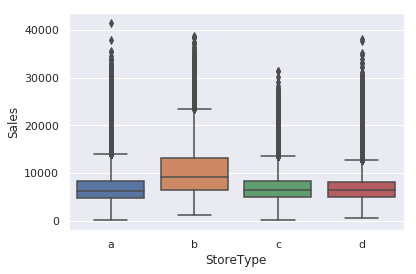

In [167]:
sns.boxplot(x='StoreType', y='Sales', data=df_train_store, order=["a", "b", "c", "d"])

__2.2.2 Assortment × Sales__

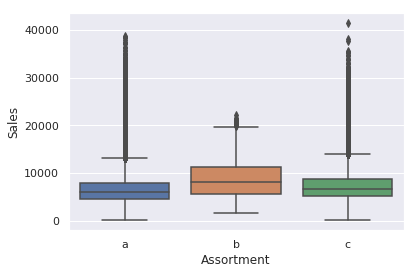

In [168]:
sns.boxplot(x='Assortment', y='Sales', data=df_train_store, order=["a", "b", "c"])

__2.2.3 CompetitionDistance × Sales__

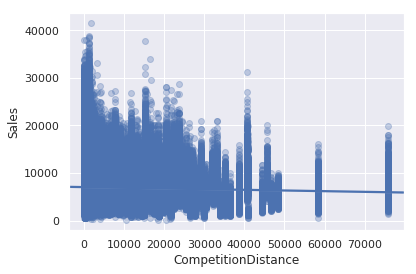

In [169]:
sns.regplot(x='CompetitionDistance', y='Sales', data = df_train_store, scatter_kws={'alpha':0.3})

常规来说,竞争对手越远，这个Rossmann商店越容易对该地图进行垄断，但是通过上图并没有看出这种趋势。如果对`CompetitionDistance`进行分组，是否会显示这种趋势？

In [170]:
df_train_store['CompetitionDist_Cat']=pd.cut(df_train_store['CompetitionDistance'], 5)

In [171]:
df_train_store.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,...,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,CompetitionDist_Cat
0,1,5,5263,555,1,1,0,1,2015,7,...,c,a,1270,9,2008,0,0,0,0,"(-55.84, 15188.0]"
1,1,4,5020,546,1,1,0,1,2015,7,...,c,a,1270,9,2008,0,0,0,0,"(-55.84, 15188.0]"
2,1,3,4782,523,1,1,0,1,2015,7,...,c,a,1270,9,2008,0,0,0,0,"(-55.84, 15188.0]"
3,1,2,5011,560,1,1,0,1,2015,7,...,c,a,1270,9,2008,0,0,0,0,"(-55.84, 15188.0]"
4,1,1,6102,612,1,1,0,1,2015,7,...,c,a,1270,9,2008,0,0,0,0,"(-55.84, 15188.0]"


In [172]:
df_train_store.groupby(by="CompetitionDist_Cat").Sales.mean()

CompetitionDist_Cat
(-55.84, 15188.0]    6956
(15188.0, 30356.0]   7042
(30356.0, 45524.0]   6472
(45524.0, 60692.0]   5980
(60692.0, 75860.0]   7775
Name: Sales, dtype: float64

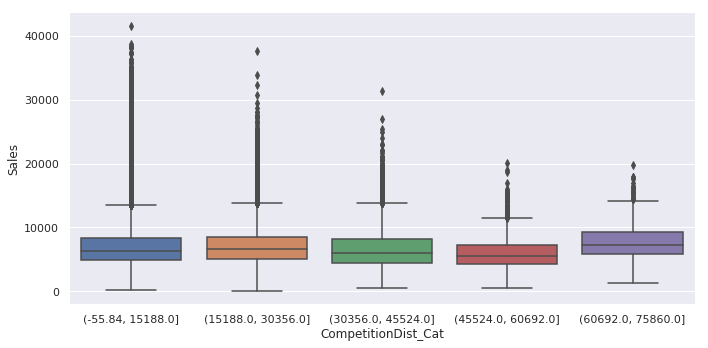

In [173]:
sns.catplot(x='CompetitionDist_Cat', y='Sales', data=df_train_store, kind = 'box', aspect = 2)

__2.2.4 CompetitionOpenSinceMonth × Sales__

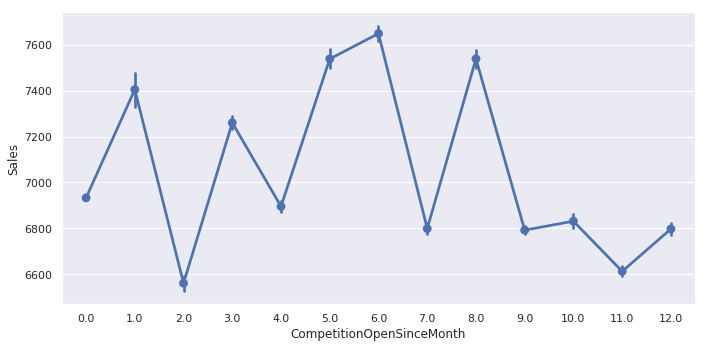

In [176]:
sns.catplot(data = df_train_store, x = 'CompetitionOpenSinceMonth', y = "Sales", kind = "point", aspect=2)

__2.2.5 CompetitionOpenSinceYear × Sales__

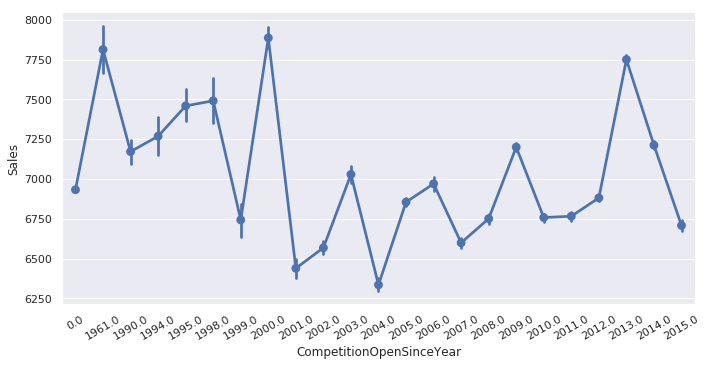

In [177]:
sns.catplot(data = df_train_store, x = 'CompetitionOpenSinceYear', y = "Sales", kind = "point",aspect=2).set_xticklabels(rotation=30) 

单独观察`CompetitionOpenSinceMonth`,`CompetitionOpenSinceYear`对`Sales`没有什么特别的意义，所以把这两个特征转化成以月为单位和Rossmann形成竞争关系的时间，来重新观察一下。

In [666]:
df_train_store['CompetitionOpenSince'] = np.where((df_train_store['CompetitionOpenSinceMonth']==0) & (df_train_store['CompetitionOpenSinceYear']==0) , 0,(df_train_store.Month - df_train_store.CompetitionOpenSinceMonth) + 
                                       (12 * (df_train_store.Year - df_train_store.CompetitionOpenSinceYear)) )

In [180]:
df_train_store.CompetitionOpenSince.describe()

count   843716
mean        40
std         55
min        -31
25%          0
50%         16
75%         73
max        645
Name: CompetitionOpenSince, dtype: float64

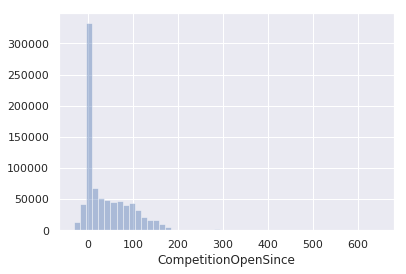

In [181]:
sns.distplot(df_train_store.CompetitionOpenSince, kde = False)

In [182]:
df_train_store['CompetitionOpenSince_Cat']=pd.cut(df_train_store['CompetitionOpenSince'], 5)

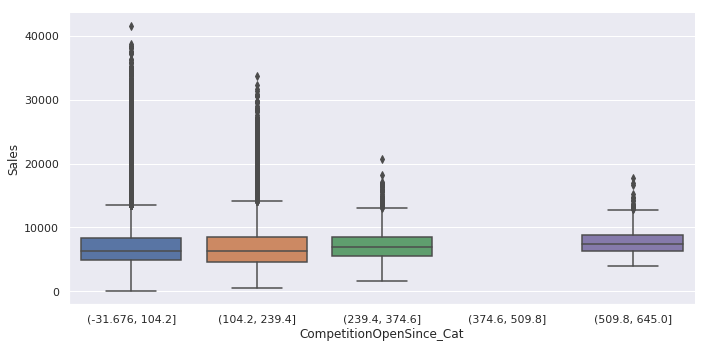

In [183]:
sns.catplot(x='CompetitionOpenSince_Cat', y='Sales', data=df_train_store, kind = 'box', aspect = 2)

可以看出随着竞争对手存在的时间越短，就会有更大的销售额

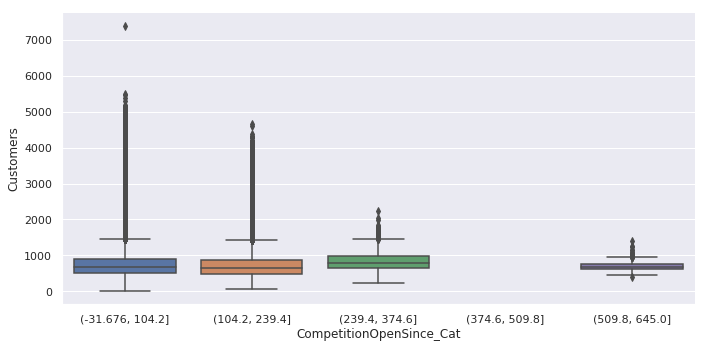

In [184]:
sns.catplot(x='CompetitionOpenSince_Cat', y='Customers', data=df_train_store, kind = 'box', aspect = 2)

可以看出随着竞争对手存在的时间越短，就会有更大的顾客流量

__2.2.6 Promo2 × Sales__

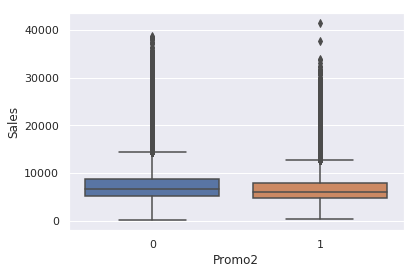

In [185]:
sns.boxplot(x='Promo2', y='Sales', data=df_train_store)

__2.2.7 Promo2SinceWeek × Sales__

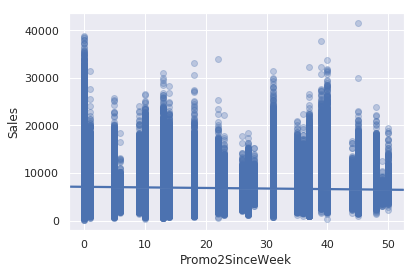

In [186]:
sns.regplot(x='Promo2SinceWeek', y='Sales', data = df_train_store, scatter_kws={'alpha':0.3})

__2.2.8 Promo2SinceYear × Sales__

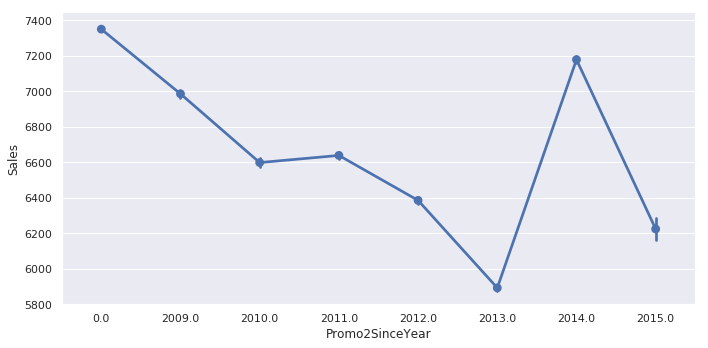

In [187]:
sns.catplot(data = df_train_store, x = 'Promo2SinceYear', y = "Sales", kind = "point",aspect=2)

__2.2.9 PromoInterval × Sales__

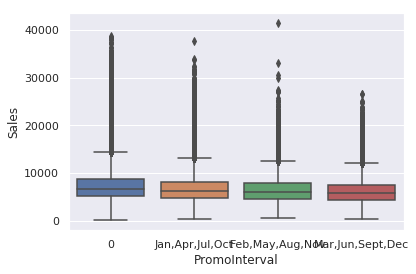

In [188]:
sns.boxplot(x='PromoInterval', y='Sales', data=df_train_store)

__2.2.10 Promo2 × Customers__

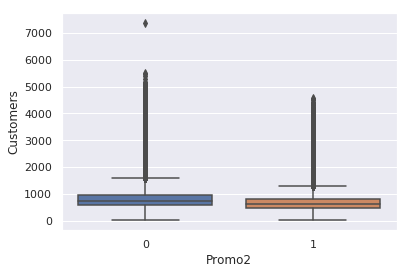

In [189]:
sns.boxplot(x = 'Promo2', y = 'Customers', data = df_train_store)

__2.2.11 CompetitionDistance × Customers__

In [192]:
df_train_store.groupby(by="CompetitionDist_Cat").Customers.mean()

CompetitionDist_Cat
(-55.84, 15188.0]    771
(15188.0, 30356.0]   692
(30356.0, 45524.0]   680
(45524.0, 60692.0]   644
(60692.0, 75860.0]   915
Name: Customers, dtype: float64

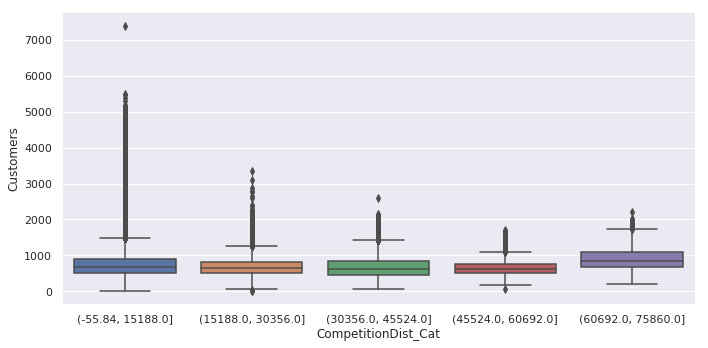

In [191]:
sns.catplot(x='CompetitionDist_Cat', y='Customers', data = df_train_store, kind = "box", aspect = 2)

呈现出`CompetitionDistance`越小`Customers`会更大的客流量

__2.2.12 StoreType × Customers__

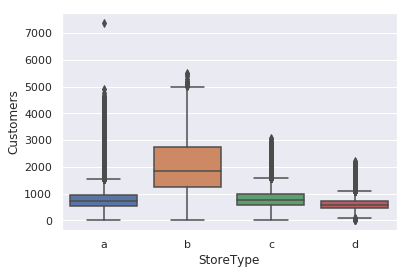

In [121]:
sns.boxplot(x = 'StoreType', y = 'Customers', data = df_train_store, order=["a", "b", "c","d"])

__2.2.13 Assortment × Customers__

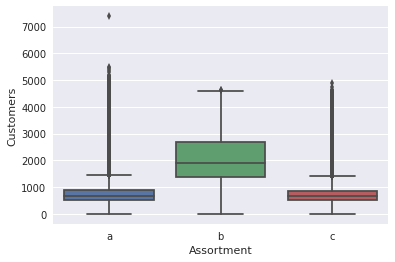

In [495]:
sns.boxplot(x = 'Assortment', y = 'Customers', data = df_train_store, order=["a", "b", "c"])

__2.2.14 StoreType × Assortment__

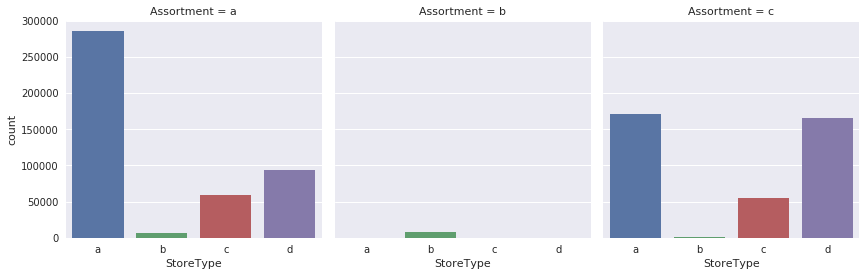

In [496]:
sns.factorplot(x='StoreType', col='Assortment', kind='count', data=df_train_store, order = ['a','b','c','d'], col_order = ['a','b','c'])

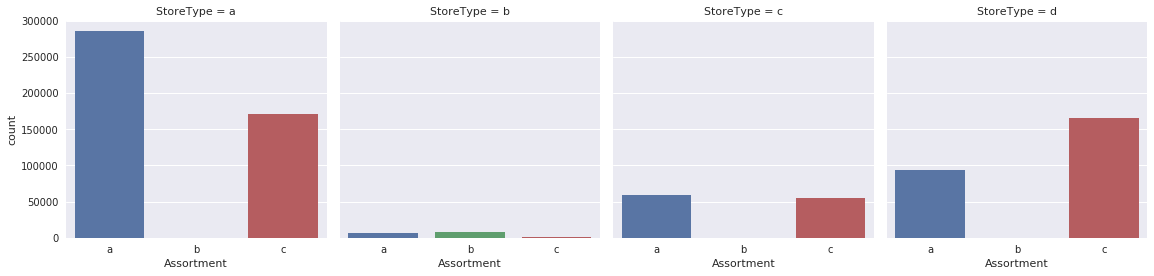

In [497]:
sns.factorplot(x='Assortment', col='StoreType', kind='count', data=df_train_store, order = ['a','b','c'], col_order = ['a','b','c','d'])

__2.2.15 Month × Promo2__

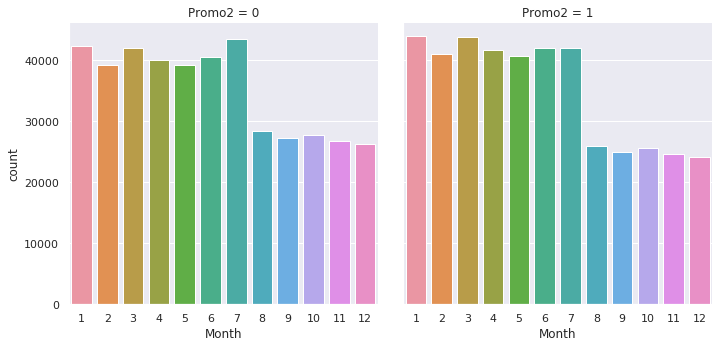

In [64]:
sns.catplot(x='Month', col='Promo2', kind='count', data=df_train_store)

* 多变量分析

__2.3.1 Promo2 × Customres × Sales__

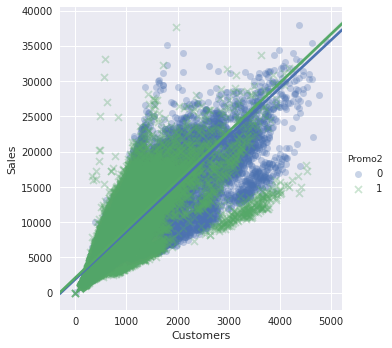

In [229]:
sns.lmplot(x='Customers', y='Sales', hue='Promo2', data=df_train_store, fit_reg=True, markers=["o", "x"], scatter_kws={'alpha':0.3})

__2.3.2 StoreType × Customres × Sales__

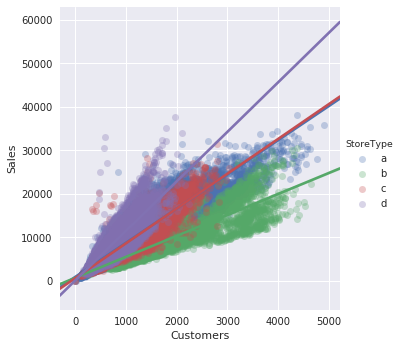

In [238]:
sns.lmplot(x='Customers', y='Sales', hue='StoreType', data=df_train_store, fit_reg=True, scatter_kws={'alpha':0.3}, hue_order=["a", "b", "c","d"])

__2.3.3 Assortment × Customres × Sales__

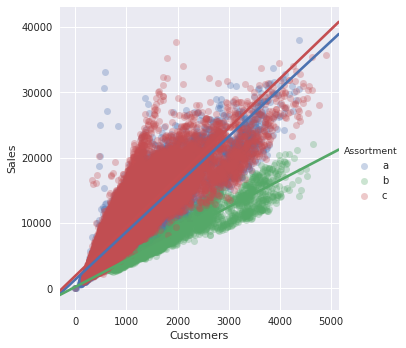

In [239]:
sns.lmplot(x='Customers', y='Sales', hue='Assortment', data=df_train_store, fit_reg=True, scatter_kws={'alpha':0.3},hue_order=["a", "b", "c"])

__2.3.4 StoreType × Assortment × Customers__

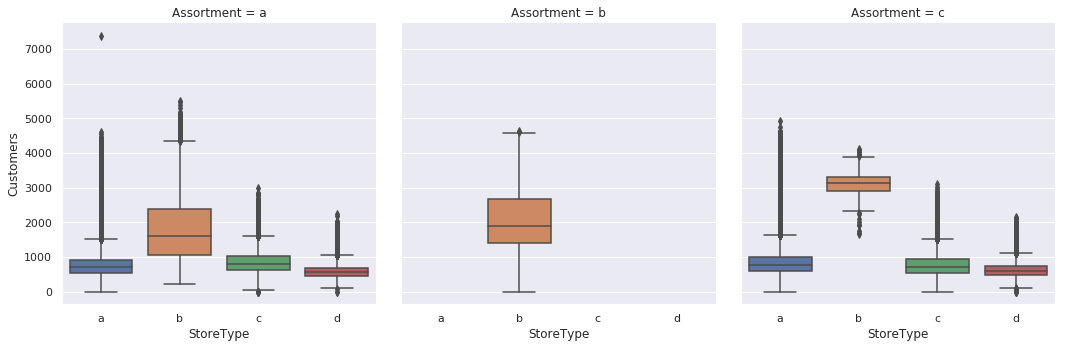

In [41]:
sns.catplot(x = 'StoreType', y = 'Customers', col = 'Assortment', data = df_train_store,
            kind = "box",
            order = ["a", "b", "c", "d"], 
            col_order=["a", "b", "c"])

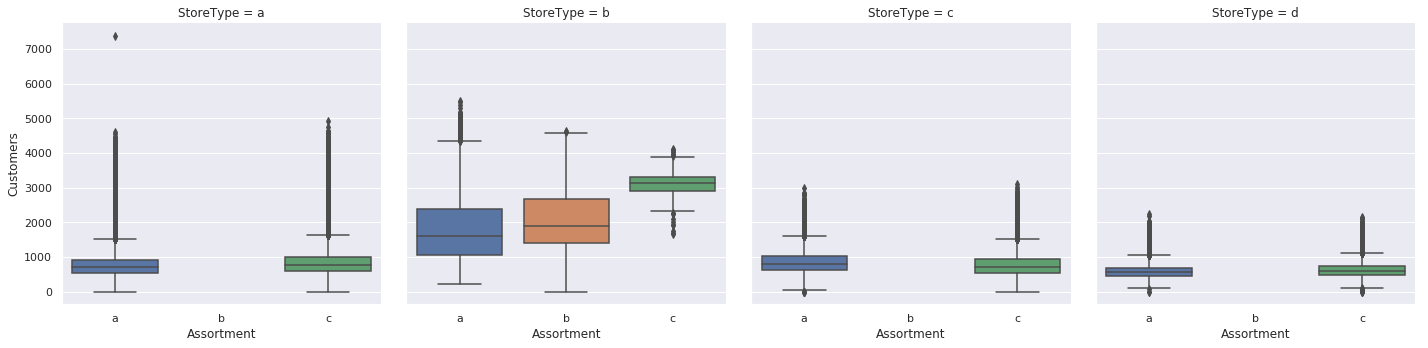

In [65]:
sns.catplot(x = 'Assortment', y = 'Customers', col = 'StoreType', data = df_train_store,
            kind = "box",
            order = ["a", "b", "c"], 
            col_order=["a", "b", "c", "d"])

__2.3.5 StoreType × Assortment × Sales__

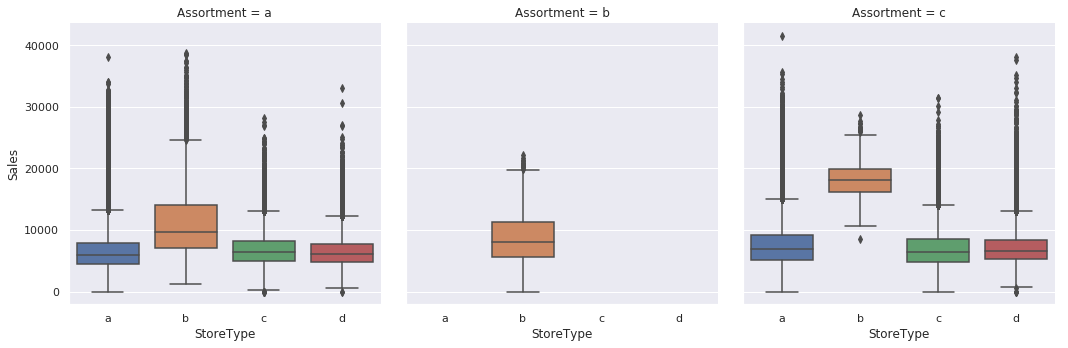

In [39]:
sns.catplot(x = 'StoreType', y = 'Sales', col = 'Assortment', data = df_train_store,
            kind="box",
            order = ["a", "b", "c", "d"], 
            col_order=["a", "b", "c"]
           )

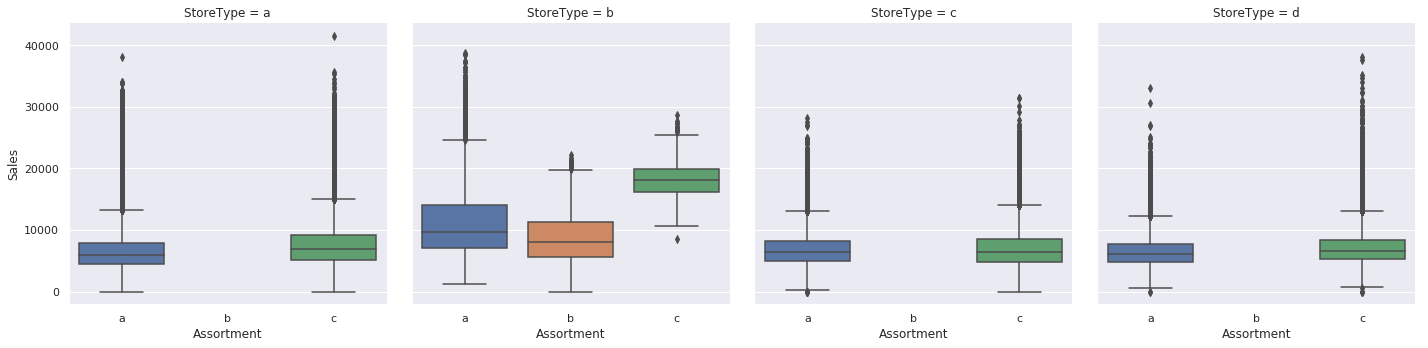

In [66]:
sns.catplot(x = 'Assortment', y = 'Sales', col = 'StoreType', data = df_train_store,
            kind="box",
            order = ["a", "b", "c"], 
            col_order=["a", "b", "c", "d"]
           )

__2.3.6 DayOfWeek × Customers × Promo2__

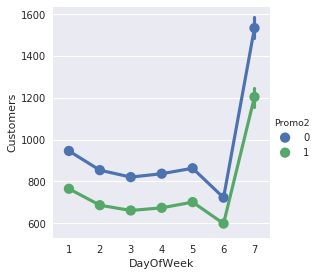

In [502]:
sns.factorplot(data = df_train_store, x = 'DayOfWeek', y = "Customers", hue = "Promo2")

__2.3.7 DayOfWeek × Sales × Promo2__

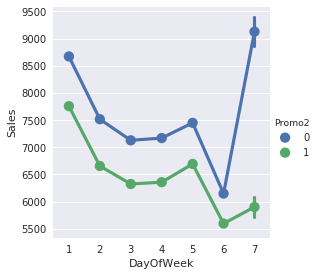

In [503]:
sns.factorplot(data = df_train_store, x = 'DayOfWeek', y = "Sales", hue = "Promo2")

__2.3.8 StoreType × CompetitionDistance × Sales__

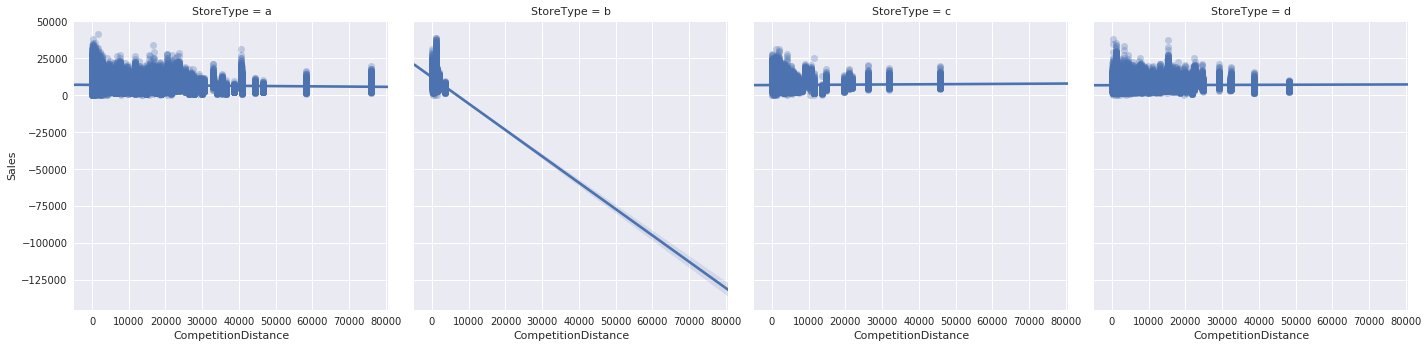

In [335]:
sns.lmplot(x='CompetitionDistance', y='Sales', col='StoreType', data=df_train_store, fit_reg=True, scatter_kws={'alpha':0.3},col_order=["a", "b", "c", "d"])

__2.3.9 StoreType × CompetitionDistance × Customers__

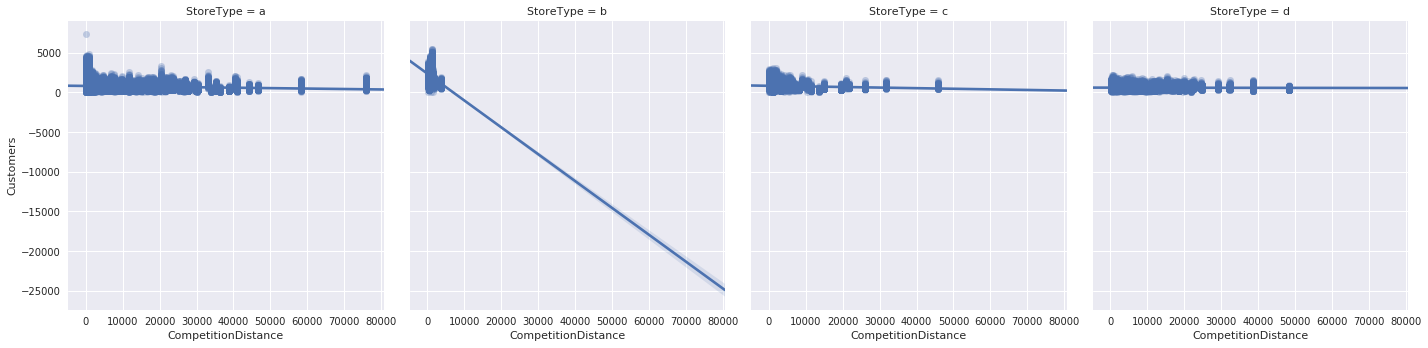

In [336]:
sns.lmplot(x='CompetitionDistance', y='Customers', col='StoreType', data=df_train_store, fit_reg=True, scatter_kws={'alpha':0.3}, col_order=["a", "b", "c", "d"])

__2.3.10 Assortment × CompetitionDistance × Sales__

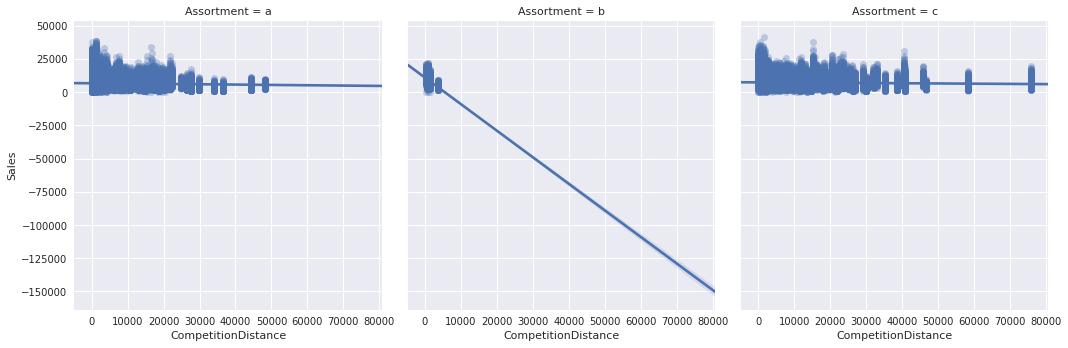

In [337]:
sns.lmplot(x='CompetitionDistance', y='Sales', col='Assortment', data=df_train_store, fit_reg=True, scatter_kws={'alpha':0.3}, col_order=["a", "b", "c"])

__2.3.11 Assortment × CompetitionDistance × Customers__

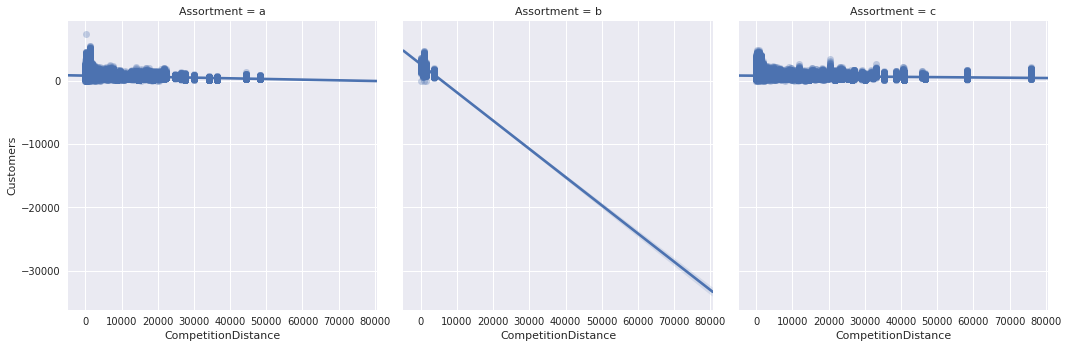

In [338]:
sns.lmplot(x='CompetitionDistance', y='Customers', col='Assortment', data=df_train_store, fit_reg=True, scatter_kws={'alpha':0.3}, col_order=["a", "b", "c"])

__2.3.12 StoreType × Customers × Season__

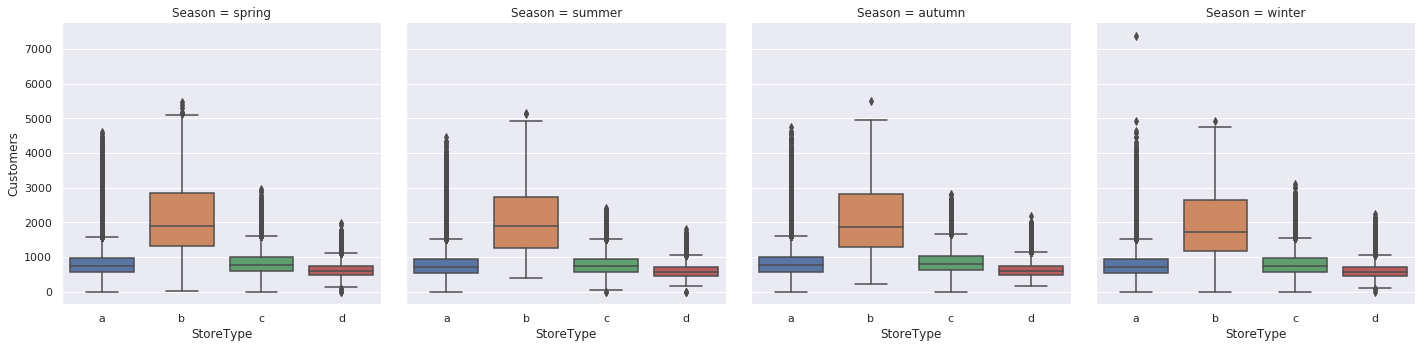

In [36]:
sns.catplot(x="StoreType", y="Customers", col="Season", data = df_train_store, 
            kind="box", 
            order = ["a","b","c","d"],
            col_order = ["spring","summer","autumn","winter"])

__2.3.13 StoreType × Sales × Season__

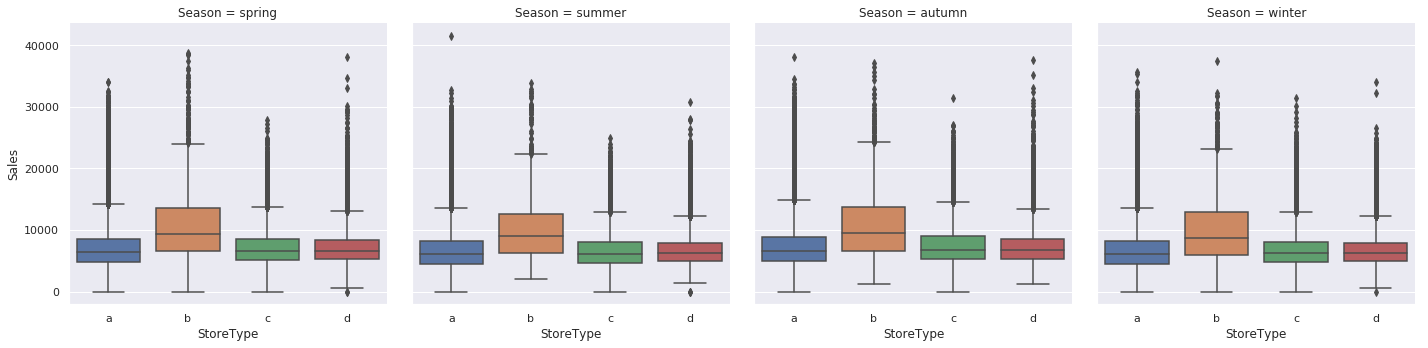

In [42]:
sns.catplot(x="StoreType", y="Sales", col="Season", data = df_train_store, 
            kind="box", 
            order = ["a","b","c","d"],
            col_order = ["spring","summer","autumn","winter"])

__2.3.14 Assortment × Customers × Season__

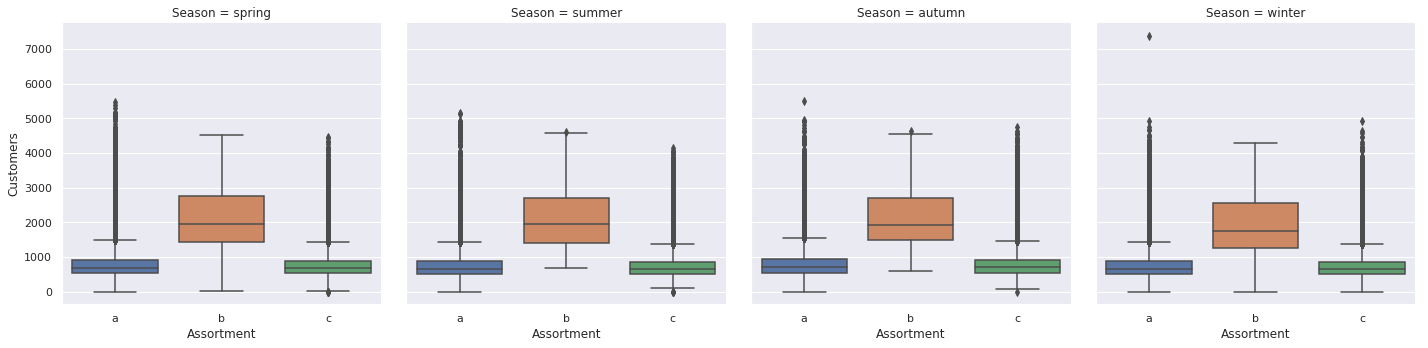

In [43]:
sns.catplot(x="Assortment", y="Customers", col="Season", data = df_train_store, 
            kind="box", 
            order = ["a","b","c"],
            col_order = ["spring","summer","autumn","winter"])

__2.3.15 Assortment × Sales × Season__

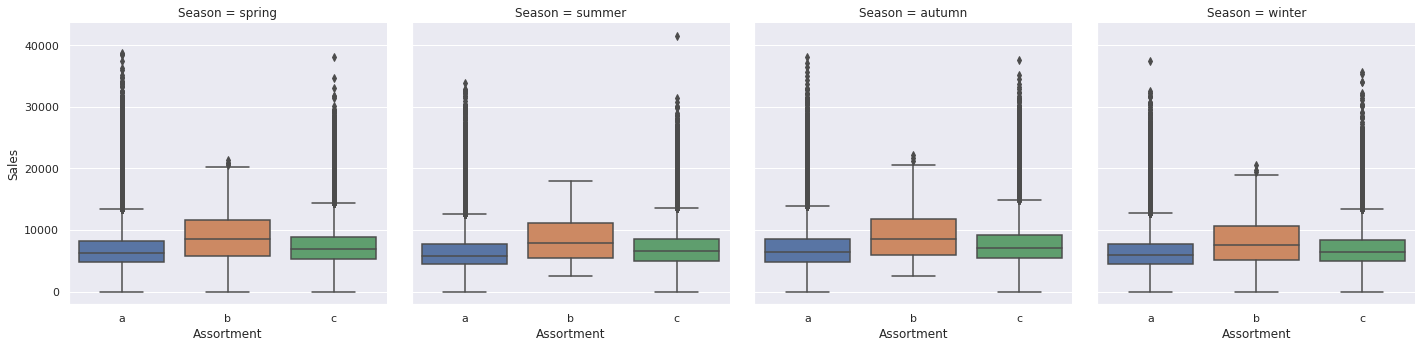

In [44]:
sns.catplot(x="Assortment", y="Sales", col="Season", data = df_train_store, 
            kind="box", 
            order = ["a","b","c"],
            col_order = ["spring","summer","autumn","winter"])

__2.3.16 Month × Sales × Promo2__

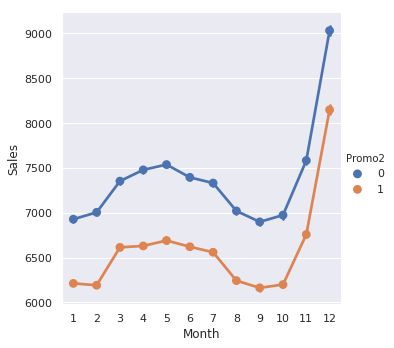

In [61]:
sns.catplot(data = df_train_store, x = 'Month', y = "Sales", 
            hue = "Promo2",
            kind="point")

__2.3.17 Month × Customers × Promo2__

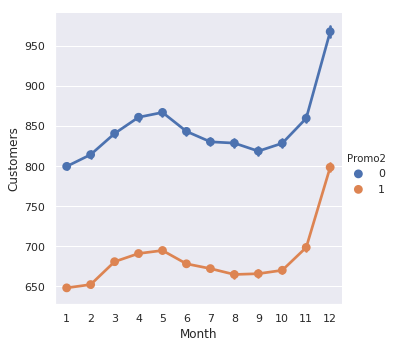

In [100]:
sns.catplot(data = df_train_store, x = 'Month', y = "Customers", 
            hue = "Promo2",
            kind="point")

__2.3.18 Xun × Sales × Season * StoreType__

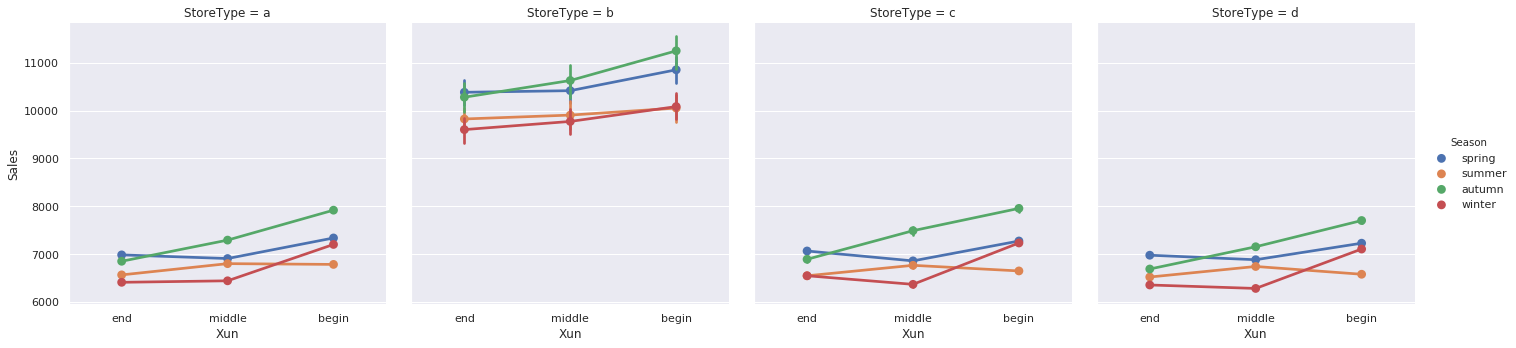

In [103]:
sns.catplot(data = df_train_store, x = 'Xun', y = "Sales", 
            hue = "Season", hue_order = ["spring","summer","autumn","winter"],
            col = "StoreType", col_order = ["a","b","c","d"],
            kind="point")

__2.3.19 Xun × Sales × Season * Assortment__

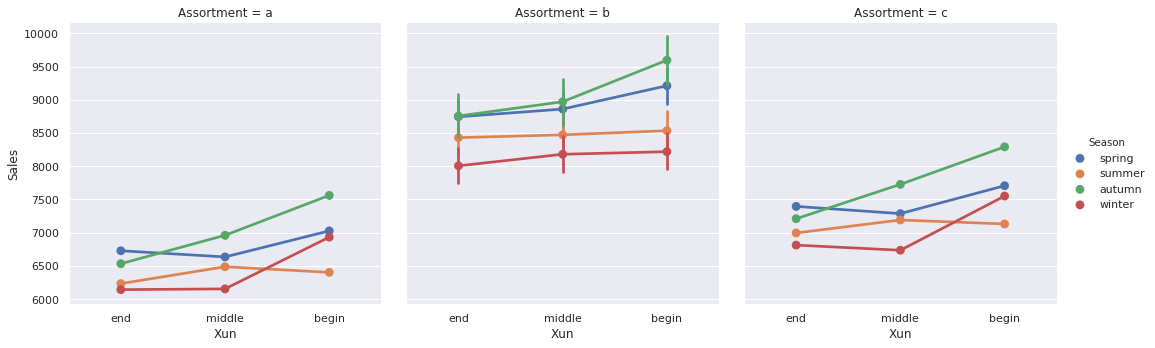

In [105]:
sns.catplot(data = df_train_store, x = 'Xun', y = "Sales", 
            hue = "Season", hue_order = ["spring","summer","autumn","winter"],
            col = "Assortment", col_order = ["a","b","c"],
            kind="point")